# Question 4: Implementing the image denoising problem

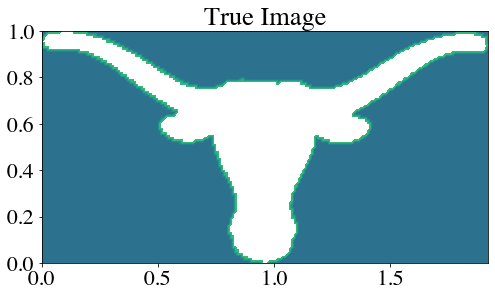

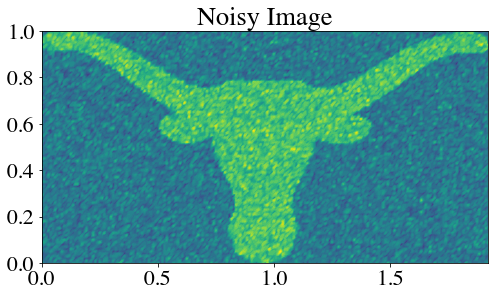

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from dolfin import *
import math
import numpy as np
import logging
from unconstrainedMinimization import InexactNewtonCG
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Times'})

logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFL').setLevel(logging.ERROR)
set_log_level(LogLevel.ERROR)


# Set the level of noise:
noise_std_dev = .3

# Load the image from file
data = np.loadtxt('image.dat', delimiter=',')
np.random.seed(seed=1)

noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.

mesh = RectangleMesh(Point(0,0),Point(Lx,Ly), 200, 100)
V = FunctionSpace(mesh, "Lagrange",1)

# Generate the true image (u_true) and the noisy data (u_0)
class Image(UserExpression):
    def __init__(self, Lx, Ly, data, **kwargs):
        super().__init__(kwargs)
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]
        
    def value_shape(self):
        return ()

trueImage  = Image(Lx, Ly, data, element=V.ufl_element())
noisyImage = Image(Lx, Ly, data+noise, element=V.ufl_element())

u_true  = interpolate(trueImage, V)
u_0     = interpolate(noisyImage, V)

vmin = np.min(u_0.vector().get_local())
vmax = np.max(u_0.vector().get_local())

plt.figure(figsize=[8,8])
plot(u_true, title="True Image", vmin=vmin, vmax = vmax)
plt.savefig("Q4_true.pdf")
plt.figure(figsize=[8,8])
plot(u_0, title="Noisy Image", vmin=vmin, vmax = vmax)
plt.savefig("Q4_Noisy.pdf")
plt.show()

# Part (a): Solving using Tikhonov (TN) regularization

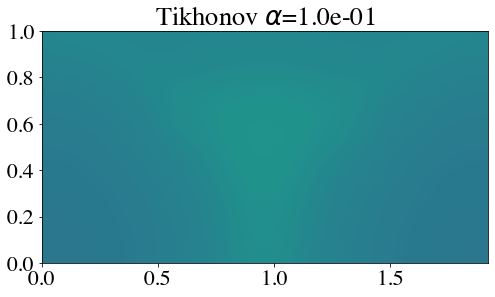

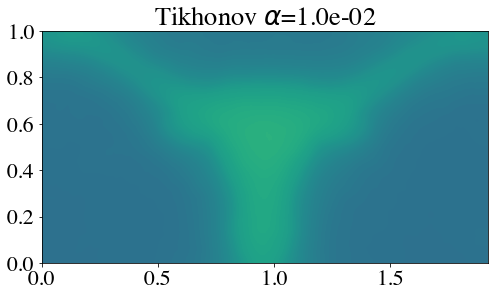

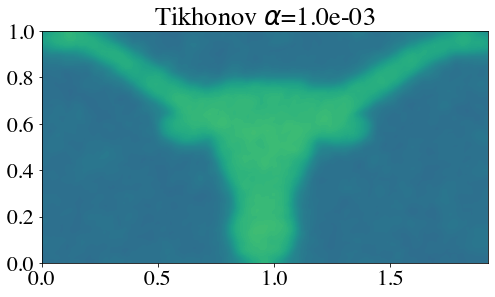

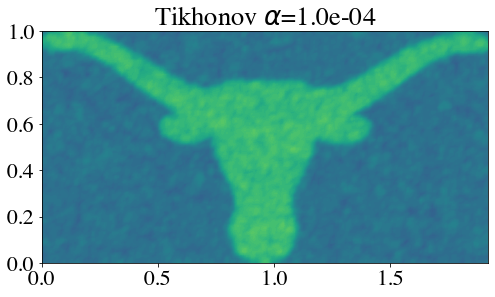

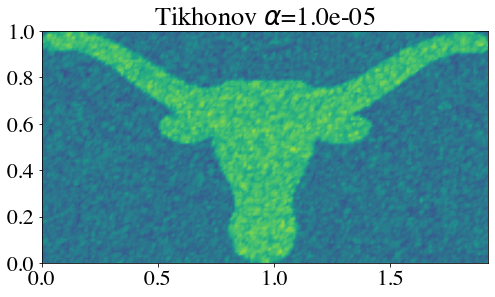

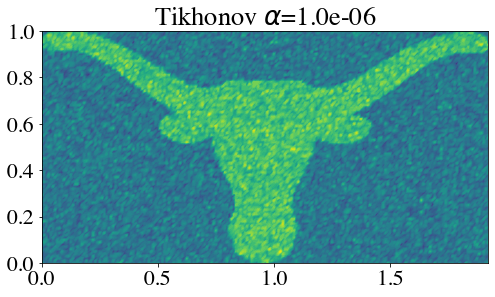

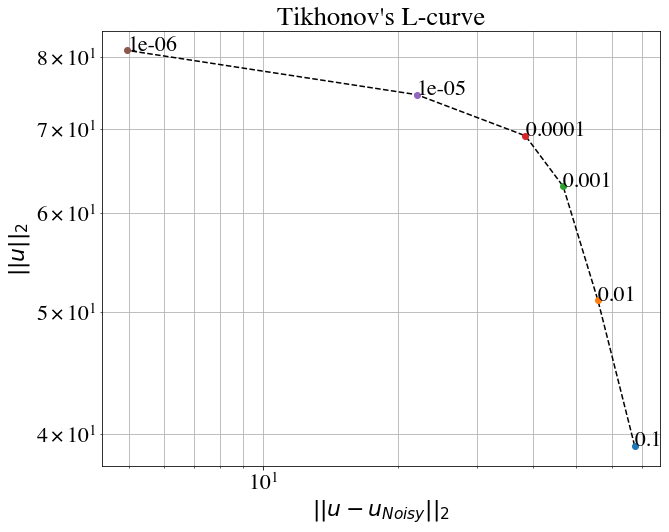

In [6]:
# Denoising using TN regularization using linear solve

# Defining functional forms
def TN_functions(alpha_val):
    """ linear form - solve lhs == rhs """
    alpha = Constant(alpha_val)
    u_trial = TrialFunction(V)
    u_test  = TestFunction(V)
    var_F_tn= (u_trial - u_0)*u_test*dx + alpha*inner(grad(u_trial), grad(u_test))*dx
    return lhs(var_F_tn), rhs(var_F_tn)

# TN regularization
alphas = np.logspace(-1,-6,6)
res_tn_norm = []
u_tn_norm   = []
u_tn_list   = []

for alpha in alphas:
    u_tn = Function(V)
    # linear solve
    a_tn, L_tn = TN_functions(alpha)
    solve(a_tn==L_tn, u_tn)

    # Misfit
    res_tn_norm.append(np.linalg.norm(u_tn.vector()[:] - u_0.vector()[:]))
    u_tn_norm.append(np.linalg.norm(u_tn.vector()[:]))
    u_tn_list.append(u_tn.copy())
    
    #plotting the image
    plt.figure(figsize=(8,8))
    plot(u_tn, title="Tikhonov $\\alpha$=%.1e" %(alpha), vmin=vmin, vmax = vmax)
    plt.savefig("Q4_TN_%.1e_.pdf" %(alpha))

# plot l-curve
fig,ax = plt.subplots(figsize=(10,8))
plt.loglog(res_tn_norm, u_tn_norm,'k--')
for i, txt in enumerate(alphas):
    ax.loglog(res_tn_norm[i], u_tn_norm[i],'o')
    ax.annotate(txt, (res_tn_norm[i], u_tn_norm[i]))

plt.grid(True, which="both")
plt.xlabel(r'$||u - u_{Noisy}||_2$')
plt.ylabel(r'$||u||_2$')
plt.title("Tikhonov's L-curve")
plt.savefig("Q4_TN_lcurve.pdf") 

## Optimal $\alpha$ is close to $10^{-3}$ since it is the point of the maximum curvature in the L-curve. Moreover, by visual inspection, it is clear that the image is free of oscillations without much diffusion for this value of regularization parameter.

# Part (b): Solving using Total variation regularization

In [7]:
# Define solver
solver = InexactNewtonCG()
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-9
solver.parameters["gdu_tolerance"] = 1e-18
solver.parameters["max_iter"] = 5000
solver.parameters["c_armijo"] = 1e-5
solver.parameters["print_level"] = 1
solver.parameters["max_backtracking_iter"] = 10

Using Symbolic Differentiation to compute the gradient
Using Symbolic Differentiation to compute the Hessian
 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    4.114996e-01    1.762820e-02   -1.244924e-01    1.000000e+00    5.000000e-01       1
  1    4.113994e-01    1.679678e-03   -1.998188e-04    1.000000e+00    5.000000e-01       2
  2    4.113992e-01    2.768329e-04   -3.836712e-07    1.000000e+00    4.873592e-01       1
  3    4.113992e-01    2.153250e-05   -4.511491e-08    1.000000e+00    1.978541e-01       2
  4    4.113992e-01    6.447811e-07   -2.028117e-10    1.000000e+00    5.518021e-02       3
  5    4.113992e-01    2.410054e-09   -5.147674e-14    1.000000e+00    9.548655e-03       4
Norm of the gradient less than tolerance
Inexact Newton CG converged in  5 nonlinear iterations and  13 linear iterations.
Final norm of the gradient 2.410054389228049e-09
Value of the cost functional 0.4113992084764307
Using Symbolic Differentiat

 63    9.518073e-02    3.716946e-03   -1.387120e-02    7.812500e-03    5.000000e-01       1
 64    9.515613e-02    3.715417e-03   -1.049359e-02    7.812500e-03    5.000000e-01       1
 65    9.513034e-02    3.672207e-03   -1.065885e-02    7.812500e-03    5.000000e-01       1
 66    9.512952e-02    3.648855e-03   -9.034272e-03    1.562500e-02    5.000000e-01       1
 67    9.512016e-02    3.529973e-03   -1.157500e-02    3.125000e-02    5.000000e-01       1
 68    9.499093e-02    3.460108e-03   -1.192748e-02    3.125000e-02    5.000000e-01       1
 69    9.496844e-02    3.360170e-03   -1.386423e-02    3.125000e-02    5.000000e-01       1
 70    9.479250e-02    3.299151e-03   -1.184281e-02    3.125000e-02    5.000000e-01       1
 71    9.471303e-02    3.238079e-03   -1.351189e-02    1.562500e-02    5.000000e-01       1
 72    9.465803e-02    3.215568e-03   -9.717743e-03    1.562500e-02    5.000000e-01       1
 73    9.463427e-02    3.158581e-03   -1.058965e-02    1.562500e-02    5.000000e

153    9.333690e-02    2.120236e-03   -6.717478e-03    7.812500e-03    5.000000e-01       1
154    9.332524e-02    2.148276e-03   -6.325398e-03    7.812500e-03    5.000000e-01       1
155    9.331636e-02    2.105525e-03   -6.690401e-03    7.812500e-03    5.000000e-01       1
156    9.330485e-02    2.133966e-03   -6.298799e-03    7.812500e-03    5.000000e-01       1
157    9.329609e-02    2.091063e-03   -6.663616e-03    7.812500e-03    5.000000e-01       1
158    9.328472e-02    2.119900e-03   -6.272499e-03    7.812500e-03    5.000000e-01       1
159    9.327608e-02    2.076843e-03   -6.637125e-03    7.812500e-03    5.000000e-01       1
160    9.326486e-02    2.106070e-03   -6.246501e-03    7.812500e-03    5.000000e-01       1
161    9.325633e-02    2.062859e-03   -6.610933e-03    7.812500e-03    5.000000e-01       1
162    9.324525e-02    2.092471e-03   -6.220806e-03    7.812500e-03    5.000000e-01       1
163    9.323684e-02    2.049104e-03   -6.585040e-03    7.812500e-03    5.000000e

243    9.262008e-02    1.635248e-03   -5.827415e-03    7.812500e-03    4.882063e-01       1
244    9.261290e-02    1.677807e-03   -5.458569e-03    7.812500e-03    4.808702e-01       1
245    9.260761e-02    1.627352e-03   -5.812683e-03    7.812500e-03    4.870877e-01       1
246    9.260049e-02    1.670183e-03   -5.444167e-03    7.812500e-03    4.797079e-01       1
247    9.259525e-02    1.619546e-03   -5.797720e-03    7.812500e-03    4.859796e-01       1
248    9.258821e-02    1.662647e-03   -5.429549e-03    7.812500e-03    4.785560e-01       1
249    9.258301e-02    1.611830e-03   -5.782541e-03    7.812500e-03    4.848821e-01       1
250    9.257603e-02    1.655200e-03   -5.414733e-03    7.812500e-03    4.774146e-01       1
251    9.257089e-02    1.604202e-03   -5.767169e-03    7.812500e-03    4.837949e-01       1
252    9.256398e-02    1.647840e-03   -5.399743e-03    7.812500e-03    4.762835e-01       1
253    9.255889e-02    1.596661e-03   -5.751630e-03    7.812500e-03    4.827181e

333    9.217420e-02    1.353324e-03   -5.177011e-03    7.812500e-03    4.467922e-01       1
334    9.216983e-02    1.406927e-03   -4.830792e-03    7.812500e-03    4.374586e-01       1
335    9.216665e-02    1.348383e-03   -5.165133e-03    7.812500e-03    4.460380e-01       1
336    9.216233e-02    1.402207e-03   -4.819416e-03    7.812500e-03    4.366593e-01       1
337    9.215919e-02    1.343484e-03   -5.153366e-03    7.812500e-03    4.452892e-01       1
338    9.215491e-02    1.397528e-03   -4.808149e-03    7.812500e-03    4.358654e-01       1
339    9.215181e-02    1.338627e-03   -5.141707e-03    7.812500e-03    4.445456e-01       1
340    9.214757e-02    1.392889e-03   -4.796988e-03    7.812500e-03    4.350767e-01       1
341    9.214451e-02    1.333809e-03   -5.130155e-03    7.812500e-03    4.438073e-01       1
342    9.214032e-02    1.388291e-03   -4.785933e-03    7.812500e-03    4.342931e-01       1
343    9.213728e-02    1.329031e-03   -5.118709e-03    7.812500e-03    4.430740e

423    9.190247e-02    1.162855e-03   -4.734772e-03    7.812500e-03    4.169483e-01       1
424    9.189971e-02    1.225912e-03   -4.409341e-03    7.812500e-03    4.055075e-01       1
425    9.189770e-02    1.159183e-03   -4.726677e-03    7.812500e-03    4.163569e-01       1
426    9.189498e-02    1.222445e-03   -4.401669e-03    7.812500e-03    4.048667e-01       1
427    9.189298e-02    1.155528e-03   -4.718637e-03    7.812500e-03    4.157677e-01       1
428    9.189028e-02    1.218995e-03   -4.394051e-03    7.812500e-03    4.042280e-01       1
429    9.188831e-02    1.151890e-03   -4.710652e-03    7.812500e-03    4.151807e-01       1
430    9.188563e-02    1.215563e-03   -4.386486e-03    7.812500e-03    4.035912e-01       1
431    9.188367e-02    1.148269e-03   -4.702719e-03    7.812500e-03    4.145957e-01       1
432    9.188102e-02    1.212147e-03   -4.378973e-03    7.812500e-03    4.029562e-01       1
433    9.187908e-02    1.144664e-03   -4.694840e-03    7.812500e-03    4.140127e

514    9.172291e-02    1.083407e-03   -4.104350e-03    7.812500e-03    3.780726e-01       1
515    9.172147e-02    1.007726e-03   -4.404973e-03    7.812500e-03    3.914100e-01       1
516    9.171965e-02    1.080525e-03   -4.098644e-03    7.812500e-03    3.774916e-01       1
517    9.171821e-02    1.004635e-03   -4.398833e-03    7.812500e-03    3.908890e-01       1
518    9.171640e-02    1.077657e-03   -4.092854e-03    7.812500e-03    3.769123e-01       1
519    9.171496e-02    1.001559e-03   -4.392583e-03    7.812500e-03    3.903700e-01       1
520    9.171317e-02    1.074804e-03   -4.086941e-03    7.812500e-03    3.763348e-01       1
521    9.171174e-02    9.984973e-04   -4.386217e-03    7.812500e-03    3.898529e-01       1
522    9.170996e-02    1.071966e-03   -4.080918e-03    7.812500e-03    3.757591e-01       1
523    9.170855e-02    9.954511e-04   -4.379774e-03    7.812500e-03    3.893379e-01       1
524    9.170679e-02    1.069144e-03   -4.074836e-03    7.812500e-03    3.751855e

604    9.160136e-02    9.700699e-04   -3.795671e-03    7.812500e-03    3.542564e-01       1
605    9.160028e-02    8.850930e-04   -4.073143e-03    7.812500e-03    3.703715e-01       1
606    9.159917e-02    9.678936e-04   -3.787241e-03    7.812500e-03    3.537778e-01       1
607    9.159810e-02    8.827090e-04   -4.063930e-03    7.812500e-03    3.699558e-01       1
608    9.159701e-02    9.657300e-04   -3.778627e-03    7.812500e-03    3.533010e-01       1
609    9.159594e-02    8.803376e-04   -4.054501e-03    7.812500e-03    3.695421e-01       1
610    9.159486e-02    9.635790e-04   -3.769807e-03    7.812500e-03    3.528261e-01       1
611    9.159380e-02    8.779787e-04   -4.044829e-03    7.812500e-03    3.691304e-01       1
612    9.159273e-02    9.614406e-04   -3.760754e-03    7.812500e-03    3.523531e-01       1
613    9.159167e-02    8.756322e-04   -4.034883e-03    7.812500e-03    3.687205e-01       1
614    9.159062e-02    9.593147e-04   -3.751439e-03    7.812500e-03    3.518819e

 15    4.425712e-02    6.697176e-04   -2.805952e-03    6.250000e-02    3.222926e-01       1
 16    4.421780e-02    6.756773e-04   -2.449213e-03    6.250000e-02    3.077386e-01       1
 17    4.420857e-02    6.185647e-04   -2.705425e-03    6.250000e-02    3.091048e-01       1
 18    4.416891e-02    6.234436e-04   -2.287989e-03    6.250000e-02    2.957527e-01       1
 19    4.416615e-02    5.753455e-04   -2.421057e-03    6.250000e-02    2.969167e-01       1
 20    4.413841e-02    5.816050e-04   -2.277222e-03    6.250000e-02    2.852334e-01       1
 21    4.413207e-02    5.360710e-04   -2.458000e-03    6.250000e-02    2.867809e-01       1
 22    4.410218e-02    5.460162e-04   -2.118071e-03    6.250000e-02    2.753260e-01       1
 23    4.410210e-02    5.033210e-04   -2.247445e-03    6.250000e-02    2.778682e-01       1
 24    4.408099e-02    5.202326e-04   -2.095078e-03    6.250000e-02    2.667833e-01       1
 25    4.407948e-02    4.767801e-04   -2.321917e-03    6.250000e-02    2.712282e

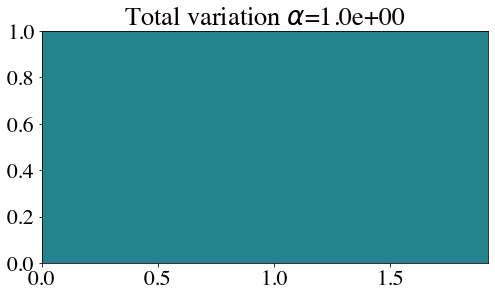

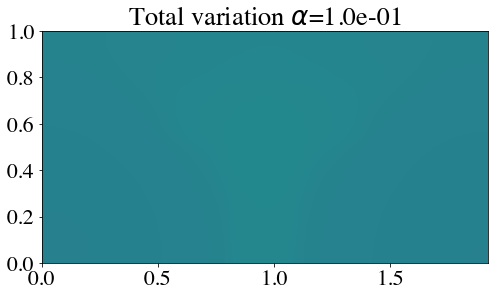

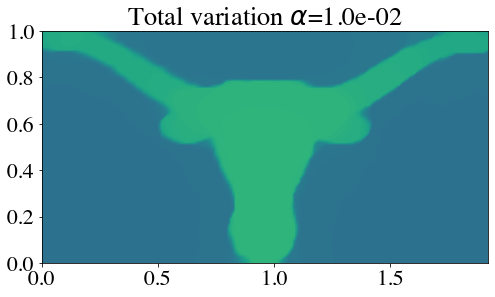

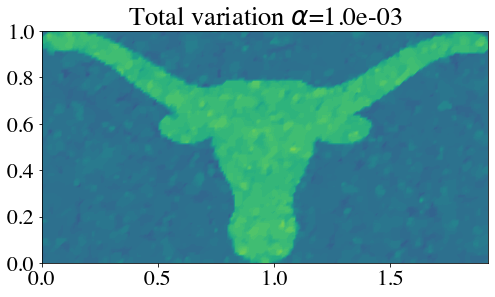

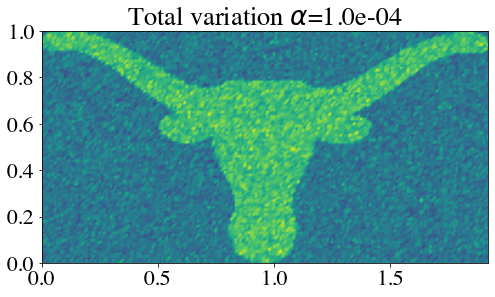

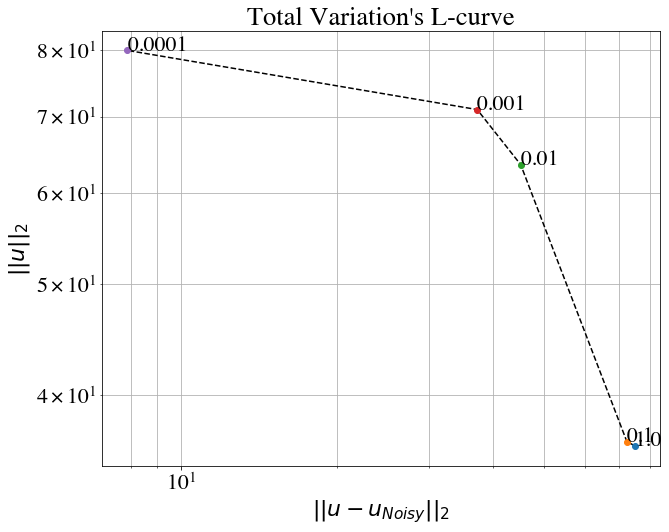

In [8]:
# Denoising using TV regularization using linear solve

# Defining functional forms
def TV_functions(alpha_val,delta_val,u_func):
    """ linear form - solve lhs == rhs """
    alpha = Constant(alpha_val) #Regularization parameters
    delta = Constant(delta_val) #Added term in the regularization
    F_tv  = Constant(0.5) * (u_func - u_0)**2 * dx + alpha * sqrt(inner(grad(u_func), grad(u_func)) + delta)*dx
    return F_tv
    
# TN regularization
alphas = np.logspace(0,-4,5)
delta  = 0.01
res_tv_norm = []
u_tv_norm   = []
u_tv_list   = []

for alpha in alphas:
    u_tv = Function(V)
    F_tv = TV_functions(alpha,delta,u_tv)
    solver.solve(F_tv, u_tv)

    # Misfit
    res_tv_norm.append(np.linalg.norm(u_tv.vector()[:] - u_0.vector()[:]))
    u_tv_norm.append(np.linalg.norm(u_tv.vector()[:]))
    u_tv_list.append(u_tv.copy())
    
    #plotting the image
    plt.figure(figsize=(8,8))
    plot(u_tv, title="Total variation $\\alpha$=%.1e" %(alpha), vmin=vmin, vmax = vmax)
    plt.savefig("Q4_TN_%.1e_.pdf" %(alpha))

# plot l-curve
fig,ax = plt.subplots(figsize=(10,8))
plt.loglog(res_tv_norm, u_tv_norm,'k--')
for i, txt in enumerate(alphas):
    ax.loglog(res_tv_norm[i], u_tv_norm[i],'o')
    ax.annotate(txt, (res_tv_norm[i], u_tv_norm[i]))

plt.grid(True, which="both")
plt.xlabel(r'$||u - u_{Noisy}||_2$')
plt.ylabel(r'$||u||_2$')
plt.title("Total Variation's L-curve")
plt.savefig("Q4_TV_lcurve.pdf") 

## It turns out that the optimal $\alpha$ for this case turns out to be $10^{-2}$.

# Effect of changing $\delta$ on the Newton iterations for convergence

Using Symbolic Differentiation to compute the gradient
Using Symbolic Differentiation to compute the Hessian
 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    1.533045e-01    2.332531e-03   -3.647865e-01    1.000000e+00    5.000000e-01       1
  1    1.425427e-01    1.336590e-03   -1.941908e-02    1.000000e+00    5.000000e-01       1
  2    1.422797e-01    2.811544e-03   -3.021029e-03    1.000000e+00    4.347456e-01       1
  3    1.417032e-01    1.212582e-03   -7.204427e-03    5.000000e-01    5.000000e-01       1
  4    1.413057e-01    6.068462e-04   -1.261276e-03    5.000000e-01    4.140871e-01       1
  5    1.411937e-01    6.557354e-04   -3.335139e-04    1.000000e+00    2.929378e-01       1
  6    1.411571e-01    3.287146e-04   -4.751881e-04    5.000000e-01    3.045092e-01       1
  7    1.411121e-01    1.115303e-04   -1.338616e-04    5.000000e-01    2.155984e-01       1
  8    1.411078e-01    3.262004e-05   -8.980724e-06    1.000000

 32    9.545618e-02    2.078495e-03   -4.825218e-03    3.125000e-02    5.000000e-01       1
 33    9.541968e-02    1.985896e-03   -6.260168e-03    3.125000e-02    5.000000e-01       1
 34    9.538254e-02    1.968855e-03   -5.368688e-03    3.125000e-02    5.000000e-01       1
 35    9.537252e-02    1.877526e-03   -6.525334e-03    3.125000e-02    5.000000e-01       1
 36    9.531209e-02    1.865759e-03   -5.576829e-03    3.125000e-02    5.000000e-01       1
 37    9.526121e-02    1.800134e-03   -6.460330e-03    1.562500e-02    5.000000e-01       1
 38    9.523788e-02    1.811506e-03   -3.267182e-03    1.562500e-02    5.000000e-01       1
 39    9.523154e-02    1.414860e-03   -1.974854e-03    2.500000e-01    5.000000e-01       1
 40    9.503941e-02    1.365590e-03   -4.754362e-03    6.250000e-02    4.472937e-01       1
 41    9.498062e-02    1.327276e-03   -3.426967e-03    3.125000e-02    4.394366e-01       1
 42    9.496770e-02    1.297209e-03   -2.312966e-03    3.125000e-02    4.332281e

 41    9.646948e-02    4.931790e-03   -2.298747e-02    1.562500e-02    5.000000e-01       1
 42    9.635292e-02    4.894138e-03   -2.142289e-02    1.562500e-02    5.000000e-01       1
 43    9.634992e-02    4.802936e-03   -2.363250e-02    1.562500e-02    5.000000e-01       1
 44    9.622406e-02    4.768737e-03   -2.129481e-02    1.562500e-02    5.000000e-01       1
 45    9.622113e-02    4.679030e-03   -2.255260e-02    1.562500e-02    5.000000e-01       1
 46    9.611359e-02    4.649370e-03   -2.107708e-02    1.562500e-02    5.000000e-01       1
 47    9.611278e-02    4.560747e-03   -2.347900e-02    1.562500e-02    5.000000e-01       1
 48    9.599035e-02    4.534010e-03   -2.096253e-02    1.562500e-02    5.000000e-01       1
 49    9.598961e-02    4.446845e-03   -2.204943e-02    1.562500e-02    5.000000e-01       1
 50    9.589065e-02    4.424659e-03   -2.072458e-02    1.562500e-02    5.000000e-01       1
 51    9.578353e-02    4.362751e-03   -2.327989e-02    7.812500e-03    5.000000e

131    9.358172e-02    2.300514e-03   -7.033637e-03    7.812500e-03    5.000000e-01       1
132    9.356832e-02    2.323743e-03   -6.636841e-03    7.812500e-03    5.000000e-01       1
133    9.355796e-02    2.282587e-03   -7.003584e-03    7.812500e-03    5.000000e-01       1
134    9.354473e-02    2.306287e-03   -6.607172e-03    7.812500e-03    5.000000e-01       1
135    9.353451e-02    2.264992e-03   -6.973779e-03    7.812500e-03    5.000000e-01       1
136    9.352145e-02    2.289156e-03   -6.577759e-03    7.812500e-03    5.000000e-01       1
137    9.351138e-02    2.247719e-03   -6.944226e-03    7.812500e-03    5.000000e-01       1
138    9.349848e-02    2.272340e-03   -6.548609e-03    7.812500e-03    5.000000e-01       1
139    9.348854e-02    2.230762e-03   -6.914931e-03    7.812500e-03    5.000000e-01       1
140    9.347581e-02    2.255833e-03   -6.519727e-03    7.812500e-03    5.000000e-01       1
141    9.346601e-02    2.214112e-03   -6.885900e-03    7.812500e-03    5.000000e

221    9.276473e-02    1.728387e-03   -5.982804e-03    7.812500e-03    5.000000e-01       1
222    9.275684e-02    1.767879e-03   -5.609612e-03    7.812500e-03    4.943751e-01       1
223    9.275100e-02    1.719416e-03   -5.968011e-03    7.812500e-03    4.999912e-01       1
224    9.274318e-02    1.759195e-03   -5.595352e-03    7.812500e-03    4.930905e-01       1
225    9.273739e-02    1.710552e-03   -5.953564e-03    7.812500e-03    4.987617e-01       1
226    9.272964e-02    1.750616e-03   -5.581412e-03    7.812500e-03    4.918178e-01       1
227    9.272390e-02    1.701792e-03   -5.939406e-03    7.812500e-03    4.975441e-01       1
228    9.271621e-02    1.742139e-03   -5.567729e-03    7.812500e-03    4.905569e-01       1
229    9.271053e-02    1.693134e-03   -5.925465e-03    7.812500e-03    4.963380e-01       1
230    9.270291e-02    1.733763e-03   -5.554228e-03    7.812500e-03    4.893074e-01       1
231    9.269727e-02    1.684576e-03   -5.911660e-03    7.812500e-03    4.951433e

311    9.226305e-02    1.410705e-03   -5.315543e-03    7.812500e-03    4.554770e-01       1
312    9.225811e-02    1.461819e-03   -4.963642e-03    7.812500e-03    4.466365e-01       1
313    9.225451e-02    1.405242e-03   -5.302312e-03    7.812500e-03    4.546560e-01       1
314    9.224962e-02    1.456587e-03   -4.950940e-03    7.812500e-03    4.457708e-01       1
315    9.224607e-02    1.399831e-03   -5.289216e-03    7.812500e-03    4.538417e-01       1
316    9.224123e-02    1.451406e-03   -4.938370e-03    7.812500e-03    4.449117e-01       1
317    9.223772e-02    1.394471e-03   -5.276251e-03    7.812500e-03    4.530338e-01       1
318    9.223293e-02    1.446276e-03   -4.925929e-03    7.812500e-03    4.440592e-01       1
319    9.222946e-02    1.389162e-03   -5.263416e-03    7.812500e-03    4.522324e-01       1
320    9.222473e-02    1.441194e-03   -4.913615e-03    7.812500e-03    4.432130e-01       1
321    9.222130e-02    1.383901e-03   -5.250708e-03    7.812500e-03    4.514372e

402    9.195488e-02    1.265327e-03   -4.497632e-03    7.812500e-03    4.127100e-01       1
403    9.195265e-02    1.200637e-03   -4.819025e-03    7.812500e-03    4.229972e-01       1
404    9.194962e-02    1.261640e-03   -4.489286e-03    7.812500e-03    4.120425e-01       1
405    9.194742e-02    1.196766e-03   -4.810309e-03    7.812500e-03    4.223804e-01       1
406    9.194441e-02    1.257974e-03   -4.481009e-03    7.812500e-03    4.113776e-01       1
407    9.194223e-02    1.192916e-03   -4.801662e-03    7.812500e-03    4.217664e-01       1
408    9.193925e-02    1.254330e-03   -4.472798e-03    7.812500e-03    4.107154e-01       1
409    9.193709e-02    1.189088e-03   -4.793082e-03    7.812500e-03    4.211551e-01       1
410    9.193414e-02    1.250708e-03   -4.464652e-03    7.812500e-03    4.100559e-01       1
411    9.193200e-02    1.185281e-03   -4.784567e-03    7.812500e-03    4.205465e-01       1
412    9.192908e-02    1.247106e-03   -4.456570e-03    7.812500e-03    4.093989e

492    9.176020e-02    1.115978e-03   -4.171733e-03    7.812500e-03    3.845591e-01       1
493    9.175867e-02    1.042577e-03   -4.476411e-03    7.812500e-03    3.972500e-01       1
494    9.175669e-02    1.112958e-03   -4.165292e-03    7.812500e-03    3.839638e-01       1
495    9.175517e-02    1.039352e-03   -4.469592e-03    7.812500e-03    3.967122e-01       1
496    9.175320e-02    1.109950e-03   -4.158890e-03    7.812500e-03    3.833694e-01       1
497    9.175169e-02    1.036137e-03   -4.462812e-03    7.812500e-03    3.961756e-01       1
498    9.174974e-02    1.106952e-03   -4.152530e-03    7.812500e-03    3.827760e-01       1
499    9.174824e-02    1.032933e-03   -4.456075e-03    7.812500e-03    3.956402e-01       1
500    9.174631e-02    1.103965e-03   -4.146219e-03    7.812500e-03    3.821837e-01       1
501    9.174482e-02    1.029739e-03   -4.449388e-03    7.812500e-03    3.951062e-01       1
502    9.174290e-02    1.100990e-03   -4.139966e-03    7.812500e-03    3.815924e

582    9.162666e-02    9.948820e-04   -3.880499e-03    7.812500e-03    3.596515e-01       1
583    9.162552e-02    9.121824e-04   -4.165168e-03    7.812500e-03    3.750783e-01       1
584    9.162426e-02    9.925582e-04   -3.873200e-03    7.812500e-03    3.591509e-01       1
585    9.162313e-02    9.096519e-04   -4.157289e-03    7.812500e-03    3.746399e-01       1
586    9.162188e-02    9.902483e-04   -3.865840e-03    7.812500e-03    3.586524e-01       1
587    9.162075e-02    9.071354e-04   -4.149339e-03    7.812500e-03    3.742038e-01       1
588    9.161951e-02    9.879524e-04   -3.858415e-03    7.812500e-03    3.581559e-01       1
589    9.161840e-02    9.046326e-04   -4.141311e-03    7.812500e-03    3.737697e-01       1
590    9.161718e-02    9.856702e-04   -3.850917e-03    7.812500e-03    3.576615e-01       1
591    9.161607e-02    9.021436e-04   -4.133197e-03    7.812500e-03    3.733377e-01       1
592    9.161486e-02    9.834016e-04   -3.843340e-03    7.812500e-03    3.571691e

673    9.133863e-02    3.596361e-07   -2.461437e-09    1.000000e+00    2.516914e-02       6
674    9.133863e-02    2.972781e-09   -1.368380e-11    1.000000e+00    7.131284e-03       5
Norm of the gradient less than tolerance
Inexact Newton CG converged in  674 nonlinear iterations and  1696 linear iterations.
Final norm of the gradient 2.9727808868962924e-09
Value of the cost functional 0.09133863184172136
Using Symbolic Differentiation to compute the gradient
Using Symbolic Differentiation to compute the Hessian
 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    2.056545e-01    5.637408e-03   -1.461275e-01    1.000000e+00    5.000000e-01       1
  1    1.384502e-01    9.692080e-03   -1.166814e-01    1.000000e+00    5.000000e-01       1
  2    1.323695e-01    1.821393e-02   -7.759573e-02    1.000000e+00    5.000000e-01       1
  3    1.237645e-01    1.744358e-02   -7.785934e-01    6.250000e-02    5.000000e-01       1
  4    1.131031e-01  

 83    9.685551e-02    7.790772e-03   -1.939051e-02    3.906250e-03    5.000000e-01       1
 84    9.683648e-02    7.748174e-03   -2.159675e-02    3.906250e-03    5.000000e-01       1
 85    9.681449e-02    7.732593e-03   -1.929417e-02    3.906250e-03    5.000000e-01       1
 86    9.679573e-02    7.690107e-03   -2.150115e-02    3.906250e-03    5.000000e-01       1
 87    9.677402e-02    7.675057e-03   -1.920185e-02    3.906250e-03    5.000000e-01       1
 88    9.675552e-02    7.632682e-03   -2.140987e-02    3.906250e-03    5.000000e-01       1
 89    9.673407e-02    7.618157e-03   -1.911332e-02    3.906250e-03    5.000000e-01       1
 90    9.671582e-02    7.575893e-03   -2.132153e-02    3.906250e-03    5.000000e-01       1
 91    9.669463e-02    7.561889e-03   -1.902756e-02    3.906250e-03    5.000000e-01       1
 92    9.667660e-02    7.519735e-03   -2.123531e-02    3.906250e-03    5.000000e-01       1
 93    9.665566e-02    7.506245e-03   -1.894387e-02    3.906250e-03    5.000000e

174    9.537017e-02    5.668117e-03   -1.858725e-02    3.906250e-03    5.000000e-01       1
175    9.535615e-02    5.671399e-03   -1.643063e-02    3.906250e-03    5.000000e-01       1
176    9.534376e-02    5.632064e-03   -1.854154e-02    3.906250e-03    5.000000e-01       1
177    9.532984e-02    5.635670e-03   -1.638791e-02    3.906250e-03    5.000000e-01       1
178    9.531752e-02    5.596366e-03   -1.849585e-02    3.906250e-03    5.000000e-01       1
179    9.530371e-02    5.600294e-03   -1.634476e-02    3.906250e-03    5.000000e-01       1
180    9.529146e-02    5.561018e-03   -1.844870e-02    3.906250e-03    5.000000e-01       1
181    9.527775e-02    5.565265e-03   -1.629991e-02    3.906250e-03    5.000000e-01       1
182    9.526557e-02    5.526019e-03   -1.839886e-02    3.906250e-03    5.000000e-01       1
183    9.525196e-02    5.530582e-03   -1.625243e-02    3.906250e-03    5.000000e-01       1
184    9.523985e-02    5.491363e-03   -1.834568e-02    3.906250e-03    5.000000e

264    9.437000e-02    4.337511e-03   -1.495266e-02    3.906250e-03    5.000000e-01       1
265    9.436045e-02    4.347735e-03   -1.321876e-02    3.906250e-03    5.000000e-01       1
266    9.435189e-02    4.313730e-03   -1.490716e-02    3.906250e-03    5.000000e-01       1
267    9.434243e-02    4.324144e-03   -1.317678e-02    3.906250e-03    5.000000e-01       1
268    9.433392e-02    4.290201e-03   -1.486167e-02    3.906250e-03    5.000000e-01       1
269    9.432455e-02    4.300804e-03   -1.313485e-02    3.906250e-03    5.000000e-01       1
270    9.431611e-02    4.266924e-03   -1.481620e-02    3.906250e-03    5.000000e-01       1
271    9.430682e-02    4.277713e-03   -1.309299e-02    3.906250e-03    5.000000e-01       1
272    9.429843e-02    4.243897e-03   -1.477075e-02    3.906250e-03    5.000000e-01       1
273    9.428924e-02    4.254871e-03   -1.305117e-02    3.906250e-03    5.000000e-01       1
274    9.428090e-02    4.221118e-03   -1.472529e-02    3.906250e-03    5.000000e

355    9.366311e-02    3.482265e-03   -1.093032e-02    3.906250e-03    5.000000e-01       1
356    9.365701e-02    3.456792e-03   -1.231393e-02    3.906250e-03    5.000000e-01       1
357    9.364990e-02    3.466968e-03   -1.090447e-02    3.906250e-03    5.000000e-01       1
358    9.364383e-02    3.441571e-03   -1.228588e-02    3.906250e-03    5.000000e-01       1
359    9.363677e-02    3.451820e-03   -1.087853e-02    3.906250e-03    5.000000e-01       1
360    9.363073e-02    3.426498e-03   -1.225771e-02    3.906250e-03    5.000000e-01       1
361    9.362373e-02    3.436819e-03   -1.085251e-02    3.906250e-03    5.000000e-01       1
362    9.361773e-02    3.411573e-03   -1.222944e-02    3.906250e-03    5.000000e-01       1
363    9.361078e-02    3.421965e-03   -1.082645e-02    3.906250e-03    5.000000e-01       1
364    9.360481e-02    3.396796e-03   -1.220110e-02    3.906250e-03    5.000000e-01       1
365    9.359792e-02    3.407257e-03   -1.080035e-02    3.906250e-03    5.000000e

445    9.314057e-02    2.910646e-03   -9.027970e-03    3.906250e-03    5.000000e-01       1
446    9.313623e-02    2.894250e-03   -1.010700e-02    3.906250e-03    5.000000e-01       1
447    9.313054e-02    2.900012e-03   -9.011256e-03    3.906250e-03    5.000000e-01       1
448    9.312623e-02    2.883708e-03   -1.008899e-02    3.906250e-03    5.000000e-01       1
449    9.312058e-02    2.889470e-03   -8.994383e-03    3.906250e-03    5.000000e-01       1
450    9.311630e-02    2.873258e-03   -1.007083e-02    3.906250e-03    5.000000e-01       1
451    9.311069e-02    2.879019e-03   -8.977387e-03    3.906250e-03    5.000000e-01       1
452    9.310643e-02    2.862898e-03   -1.005255e-02    3.906250e-03    5.000000e-01       1
453    9.310086e-02    2.868657e-03   -8.960300e-03    3.906250e-03    5.000000e-01       1
454    9.309663e-02    2.852628e-03   -1.003419e-02    3.906250e-03    5.000000e-01       1
455    9.309110e-02    2.858383e-03   -8.943152e-03    3.906250e-03    5.000000e

535    9.274365e-02    2.508660e-03   -8.352758e-03    3.906250e-03    5.000000e-01       1
536    9.274016e-02    2.496204e-03   -9.379460e-03    3.906250e-03    5.000000e-01       1
537    9.273583e-02    2.501185e-03   -8.337608e-03    3.906250e-03    5.000000e-01       1
538    9.273235e-02    2.488820e-03   -9.362740e-03    3.906250e-03    5.000000e-01       1
539    9.272805e-02    2.493781e-03   -8.322266e-03    3.906250e-03    5.000000e-01       1
540    9.272459e-02    2.481506e-03   -9.345780e-03    3.906250e-03    5.000000e-01       1
541    9.272031e-02    2.486447e-03   -8.306722e-03    3.906250e-03    5.000000e-01       1
542    9.271686e-02    2.474262e-03   -9.328565e-03    3.906250e-03    5.000000e-01       1
543    9.271261e-02    2.479183e-03   -8.290960e-03    3.906250e-03    5.000000e-01       1
544    9.270917e-02    2.467087e-03   -9.311066e-03    3.906250e-03    5.000000e-01       1
545    9.270495e-02    2.471987e-03   -8.274952e-03    3.906250e-03    5.000000e

625    9.242066e-02    2.208720e-03   -6.897384e-03    3.906250e-03    5.000000e-01       1
626    9.241822e-02    2.205670e-03   -7.682209e-03    3.906250e-03    5.000000e-01       1
627    9.241424e-02    2.202808e-03   -6.887760e-03    3.906250e-03    5.000000e-01       1
628    9.241181e-02    2.199851e-03   -7.671844e-03    3.906250e-03    5.000000e-01       1
629    9.240785e-02    2.196936e-03   -6.878112e-03    3.906250e-03    5.000000e-01       1
630    9.240544e-02    2.194073e-03   -7.661468e-03    3.906250e-03    5.000000e-01       1
631    9.240149e-02    2.191107e-03   -6.868450e-03    3.906250e-03    5.000000e-01       1
632    9.239909e-02    2.188341e-03   -7.651094e-03    3.906250e-03    5.000000e-01       1
633    9.239517e-02    2.185324e-03   -6.858789e-03    3.906250e-03    5.000000e-01       1
634    9.239278e-02    2.182655e-03   -7.640735e-03    3.906250e-03    5.000000e-01       1
635    9.238888e-02    2.179589e-03   -6.849143e-03    3.906250e-03    5.000000e

715    9.215710e-02    1.988213e-03   -6.546121e-03    3.906250e-03    5.000000e-01       1
716    9.215500e-02    1.989407e-03   -7.305753e-03    3.906250e-03    5.000000e-01       1
717    9.215168e-02    1.984177e-03   -6.539018e-03    3.906250e-03    5.000000e-01       1
718    9.214959e-02    1.985458e-03   -7.298213e-03    3.906250e-03    5.000000e-01       1
719    9.214628e-02    1.980174e-03   -6.531979e-03    3.906250e-03    5.000000e-01       1
720    9.214419e-02    1.981542e-03   -7.290742e-03    3.906250e-03    5.000000e-01       1
721    9.214090e-02    1.976205e-03   -6.525000e-03    3.906250e-03    5.000000e-01       1
722    9.213882e-02    1.977659e-03   -7.283334e-03    3.906250e-03    5.000000e-01       1
723    9.213554e-02    1.972268e-03   -6.518078e-03    3.906250e-03    5.000000e-01       1
724    9.213348e-02    1.973808e-03   -7.275983e-03    3.906250e-03    5.000000e-01       1
725    9.213021e-02    1.968364e-03   -6.511208e-03    3.906250e-03    5.000000e

805    9.193323e-02    1.834409e-03   -6.257804e-03    3.906250e-03    5.000000e-01       1
806    9.193144e-02    1.839080e-03   -6.996860e-03    3.906250e-03    5.000000e-01       1
807    9.192865e-02    1.831480e-03   -6.251888e-03    3.906250e-03    5.000000e-01       1
808    9.192686e-02    1.836217e-03   -6.990481e-03    3.906250e-03    5.000000e-01       1
809    9.192408e-02    1.828564e-03   -6.246041e-03    3.906250e-03    5.000000e-01       1
810    9.192230e-02    1.833366e-03   -6.984179e-03    3.906250e-03    5.000000e-01       1
811    9.191952e-02    1.825660e-03   -6.240273e-03    3.906250e-03    5.000000e-01       1
812    9.191774e-02    1.830527e-03   -6.977961e-03    3.906250e-03    5.000000e-01       1
813    9.191498e-02    1.822766e-03   -6.234594e-03    3.906250e-03    5.000000e-01       1
814    9.191320e-02    1.827696e-03   -6.971837e-03    3.906250e-03    5.000000e-01       1
815    9.191044e-02    1.819881e-03   -6.229010e-03    3.906250e-03    5.000000e

896    9.172989e-02    1.717078e-03   -6.753193e-03    3.906250e-03    4.917081e-01       1
897    9.172722e-02    1.707160e-03   -6.026553e-03    3.906250e-03    4.927551e-01       1
898    9.172535e-02    1.714497e-03   -6.727297e-03    3.906250e-03    4.913299e-01       1
899    9.172267e-02    1.704526e-03   -5.998549e-03    3.906250e-03    4.923846e-01       1
900    9.172077e-02    1.711908e-03   -6.685518e-03    3.906250e-03    4.909507e-01       1
901    9.171806e-02    1.701881e-03   -5.949531e-03    3.906250e-03    4.920127e-01       1
902    9.171608e-02    1.709305e-03   -6.604293e-03    3.906250e-03    4.905697e-01       1
903    9.171326e-02    1.699212e-03   -5.840456e-03    3.906250e-03    4.916385e-01       1
904    9.171106e-02    1.706646e-03   -6.390524e-03    3.906250e-03    4.901849e-01       1
905    9.170765e-02    1.696262e-03   -5.478042e-03    3.906250e-03    4.912560e-01       1
906    9.170521e-02    1.706117e-03   -5.631304e-03    3.906250e-03    4.897591e

986    9.151975e-02    1.571943e-03   -5.531140e-03    3.906250e-03    4.687214e-01       1
987    9.151653e-02    1.550795e-03   -4.958760e-03    3.906250e-03    4.714705e-01       1
988    9.151529e-02    1.569148e-03   -5.525575e-03    3.906250e-03    4.682882e-01       1
989    9.151208e-02    1.547951e-03   -4.953576e-03    3.906250e-03    4.710511e-01       1
990    9.151084e-02    1.566378e-03   -5.519955e-03    3.906250e-03    4.678587e-01       1
991    9.150765e-02    1.545134e-03   -4.948339e-03    3.906250e-03    4.706352e-01       1
992    9.150642e-02    1.563635e-03   -5.514290e-03    3.906250e-03    4.674327e-01       1
993    9.150323e-02    1.542342e-03   -4.943059e-03    3.906250e-03    4.702229e-01       1
994    9.150201e-02    1.560918e-03   -5.508594e-03    3.906250e-03    4.670103e-01       1
995    9.149884e-02    1.539576e-03   -4.937749e-03    3.906250e-03    4.698142e-01       1
996    9.149762e-02    1.558226e-03   -5.502876e-03    3.906250e-03    4.665914e

1076    9.133940e-02    1.467464e-03   -5.285871e-03    3.906250e-03    4.521987e-01       1
1077    9.133676e-02    1.444063e-03   -4.729522e-03    3.906250e-03    4.555330e-01       1
1078    9.133588e-02    1.465531e-03   -5.280984e-03    3.906250e-03    4.518863e-01       1
1079    9.133325e-02    1.442081e-03   -4.724959e-03    3.906250e-03    4.552328e-01       1
1080    9.133238e-02    1.463612e-03   -5.276132e-03    3.906250e-03    4.515760e-01       1
1081    9.132976e-02    1.440112e-03   -4.720428e-03    3.906250e-03    4.549346e-01       1
1082    9.132890e-02    1.461707e-03   -5.271312e-03    3.906250e-03    4.512677e-01       1
1083    9.132628e-02    1.438159e-03   -4.715926e-03    3.906250e-03    4.546385e-01       1
1084    9.132543e-02    1.459816e-03   -5.266520e-03    3.906250e-03    4.509615e-01       1
1085    9.132283e-02    1.436219e-03   -4.711451e-03    3.906250e-03    4.543443e-01       1
1086    9.132198e-02    1.457939e-03   -5.261754e-03    3.906250e-03  

1166    9.119756e-02    1.391847e-03   -5.084234e-03    3.906250e-03    4.398010e-01       1
1167    9.119536e-02    1.366320e-03   -4.541130e-03    3.906250e-03    4.436412e-01       1
1168    9.119476e-02    1.390364e-03   -5.079815e-03    3.906250e-03    4.395540e-01       1
1169    9.119257e-02    1.364791e-03   -4.536995e-03    3.906250e-03    4.434047e-01       1
1170    9.119198e-02    1.388887e-03   -5.075378e-03    3.906250e-03    4.393080e-01       1
1171    9.118980e-02    1.363268e-03   -4.532843e-03    3.906250e-03    4.431691e-01       1
1172    9.118921e-02    1.387416e-03   -5.070923e-03    3.906250e-03    4.390629e-01       1
1173    9.118704e-02    1.361753e-03   -4.528674e-03    3.906250e-03    4.429345e-01       1
1174    9.118645e-02    1.385952e-03   -5.066447e-03    3.906250e-03    4.388188e-01       1
1175    9.118429e-02    1.360244e-03   -4.524486e-03    3.906250e-03    4.427007e-01       1
1176    9.118371e-02    1.384495e-03   -5.061951e-03    3.906250e-03  

1256    9.108646e-02    1.331334e-03   -4.865284e-03    3.906250e-03    4.295971e-01       1
1257    9.108470e-02    1.303853e-03   -4.336698e-03    3.906250e-03    4.338899e-01       1
1258    9.108433e-02    1.330111e-03   -4.860504e-03    3.906250e-03    4.293885e-01       1
1259    9.108258e-02    1.302587e-03   -4.332248e-03    3.906250e-03    4.336907e-01       1
1260    9.108222e-02    1.328890e-03   -4.855752e-03    3.906250e-03    4.291800e-01       1
1261    9.108048e-02    1.301322e-03   -4.327824e-03    3.906250e-03    4.334915e-01       1
1262    9.108011e-02    1.327669e-03   -4.851026e-03    3.906250e-03    4.289715e-01       1
1263    9.107838e-02    1.300057e-03   -4.323424e-03    3.906250e-03    4.332924e-01       1
1264    9.107803e-02    1.326449e-03   -4.846325e-03    3.906250e-03    4.287630e-01       1
1265    9.107630e-02    1.298792e-03   -4.319047e-03    3.906250e-03    4.330932e-01       1
1266    9.107595e-02    1.325229e-03   -4.841646e-03    3.906250e-03  

1346    9.100228e-02    1.275402e-03   -4.669417e-03    3.906250e-03    4.199581e-01       1
1347    9.100088e-02    1.245875e-03   -4.154386e-03    3.906250e-03    4.246778e-01       1
1348    9.100065e-02    1.274111e-03   -4.665475e-03    3.906250e-03    4.197332e-01       1
1349    9.099925e-02    1.244536e-03   -4.150719e-03    3.906250e-03    4.244628e-01       1
1350    9.099902e-02    1.272816e-03   -4.661548e-03    3.906250e-03    4.195076e-01       1
1351    9.099763e-02    1.243194e-03   -4.147067e-03    3.906250e-03    4.242472e-01       1
1352    9.099741e-02    1.271519e-03   -4.657636e-03    3.906250e-03    4.192814e-01       1
1353    9.099602e-02    1.241850e-03   -4.143429e-03    3.906250e-03    4.240310e-01       1
1354    9.099580e-02    1.270219e-03   -4.653739e-03    3.906250e-03    4.190546e-01       1
1355    9.099442e-02    1.240502e-03   -4.139805e-03    3.906250e-03    4.238142e-01       1
1356    9.099420e-02    1.268916e-03   -4.649857e-03    3.906250e-03  

1436    9.093629e-02    1.215450e-03   -4.507389e-03    3.906250e-03    4.093746e-01       1
1437    9.093513e-02    1.183763e-03   -4.003842e-03    3.906250e-03    4.145765e-01       1
1438    9.093497e-02    1.214123e-03   -4.504154e-03    3.906250e-03    4.091368e-01       1
1439    9.093382e-02    1.182390e-03   -4.000838e-03    3.906250e-03    4.143501e-01       1
1440    9.093366e-02    1.212799e-03   -4.500932e-03    3.906250e-03    4.088994e-01       1
1441    9.093251e-02    1.181019e-03   -3.997847e-03    3.906250e-03    4.141242e-01       1
1442    9.093235e-02    1.211479e-03   -4.497724e-03    3.906250e-03    4.086623e-01       1
1443    9.093121e-02    1.179652e-03   -3.994869e-03    3.906250e-03    4.138986e-01       1
1444    9.093105e-02    1.210161e-03   -4.494529e-03    3.906250e-03    4.084257e-01       1
1445    9.092992e-02    1.178288e-03   -3.991903e-03    3.906250e-03    4.136735e-01       1
1446    9.092976e-02    1.208847e-03   -4.491347e-03    3.906250e-03  

1526    9.088175e-02    1.160230e-03   -4.369570e-03    3.906250e-03    3.993333e-01       1
1527    9.088077e-02    1.126567e-03   -3.875961e-03    3.906250e-03    4.050495e-01       1
1528    9.088063e-02    1.159130e-03   -4.366534e-03    3.906250e-03    3.991302e-01       1
1529    9.087966e-02    1.125427e-03   -3.873147e-03    3.906250e-03    4.048575e-01       1
1530    9.087952e-02    1.158036e-03   -4.363492e-03    3.906250e-03    3.989281e-01       1
1531    9.087855e-02    1.124292e-03   -3.870326e-03    3.906250e-03    4.046664e-01       1
1532    9.087841e-02    1.156948e-03   -4.360442e-03    3.906250e-03    3.987270e-01       1
1533    9.087744e-02    1.123164e-03   -3.867499e-03    3.906250e-03    4.044763e-01       1
1534    9.087730e-02    1.155867e-03   -4.357383e-03    3.906250e-03    3.985269e-01       1
1535    9.087634e-02    1.122041e-03   -3.864663e-03    3.906250e-03    4.042872e-01       1
1536    9.087619e-02    1.154791e-03   -4.354316e-03    3.906250e-03  

1616    9.083439e-02    1.116400e-03   -4.211064e-03    3.906250e-03    3.911365e-01       1
1617    9.083358e-02    1.080999e-03   -3.729160e-03    3.906250e-03    3.973251e-01       1
1618    9.083339e-02    1.115548e-03   -4.206532e-03    3.906250e-03    3.909748e-01       1
1619    9.083258e-02    1.080110e-03   -3.724981e-03    3.906250e-03    3.971734e-01       1
1620    9.083240e-02    1.114701e-03   -4.201935e-03    3.906250e-03    3.908140e-01       1
1621    9.083159e-02    1.079226e-03   -3.720745e-03    3.906250e-03    3.970226e-01       1
1622    9.083140e-02    1.113860e-03   -4.197274e-03    3.906250e-03    3.906541e-01       1
1623    9.083060e-02    1.078349e-03   -3.716457e-03    3.906250e-03    3.968728e-01       1
1624    9.083041e-02    1.113024e-03   -4.192554e-03    3.906250e-03    3.904952e-01       1
1625    9.082961e-02    1.077477e-03   -3.712121e-03    3.906250e-03    3.967239e-01       1
1626    9.082941e-02    1.112195e-03   -4.187780e-03    3.906250e-03  

1705    9.062356e-02    2.031296e-03   -4.894383e-03    1.562500e-02    5.000000e-01       1
1706    9.060437e-02    2.047465e-03   -6.019912e-03    7.812500e-03    5.000000e-01       1
1707    9.059464e-02    2.011397e-03   -4.374662e-03    3.906250e-03    5.000000e-01       1
1708    9.059225e-02    2.022923e-03   -1.032335e-03    7.812500e-03    5.000000e-01       1
1709    9.058983e-02    1.977650e-03   -6.472332e-04    7.812500e-03    5.000000e-01       1
1710    9.057533e-02    1.797110e-03   -5.944730e-04    1.250000e-01    5.000000e-01       2
1711    9.056942e-02    1.798257e-03   -2.433320e-03    3.906250e-03    5.000000e-01       1
1712    9.055994e-02    1.639906e-03   -5.827461e-04    1.250000e-01    5.000000e-01       2
1713    9.054347e-02    1.579208e-03   -4.300271e-03    3.906250e-03    4.815546e-01       1
1714    9.053246e-02    1.518417e-03   -4.369660e-04    1.250000e-01    4.725587e-01       3
1715    9.051576e-02    1.463786e-03   -8.724834e-04    6.250000e-02  

 47    1.043230e-01    1.103820e-02   -4.937562e-02    3.906250e-03    5.000000e-01       1
 48    1.042997e-01    1.097968e-02   -5.635233e-02    3.906250e-03    5.000000e-01       1
 49    1.042244e-01    1.095822e-02   -5.050287e-02    3.906250e-03    5.000000e-01       1
 50    1.042152e-01    1.090016e-02   -5.535803e-02    3.906250e-03    5.000000e-01       1
 51    1.041309e-01    1.087924e-02   -5.029503e-02    3.906250e-03    5.000000e-01       1
 52    1.041288e-01    1.082156e-02   -5.411461e-02    3.906250e-03    5.000000e-01       1
 53    1.040429e-01    1.080118e-02   -5.009938e-02    3.906250e-03    5.000000e-01       1
 54    1.039886e-01    1.076245e-02   -5.400469e-02    1.953125e-03    5.000000e-01       1
 55    1.039637e-01    1.076287e-02   -3.431324e-02    1.953125e-03    5.000000e-01       1
 56    1.039556e-01    1.070569e-02   -3.450315e-02    3.906250e-03    5.000000e-01       1
 57    1.039176e-01    1.068016e-02   -4.193578e-02    3.906250e-03    5.000000e

137    1.010956e-01    8.097564e-03   -2.442942e-02    1.953125e-03    5.000000e-01       1
138    1.010823e-01    8.071707e-03   -2.647582e-02    1.953125e-03    5.000000e-01       1
139    1.010667e-01    8.070810e-03   -2.443413e-02    1.953125e-03    5.000000e-01       1
140    1.010535e-01    8.044985e-03   -2.647761e-02    1.953125e-03    5.000000e-01       1
141    1.010378e-01    8.044205e-03   -2.442692e-02    1.953125e-03    5.000000e-01       1
142    1.010248e-01    8.018412e-03   -2.646999e-02    1.953125e-03    5.000000e-01       1
143    1.010092e-01    8.017748e-03   -2.441268e-02    1.953125e-03    5.000000e-01       1
144    1.009962e-01    7.991988e-03   -2.645588e-02    1.953125e-03    5.000000e-01       1
145    1.009807e-01    7.991438e-03   -2.439329e-02    1.953125e-03    5.000000e-01       1
146    1.009679e-01    7.965711e-03   -2.643685e-02    1.953125e-03    5.000000e-01       1
147    1.009524e-01    7.965274e-03   -2.437001e-02    1.953125e-03    5.000000e

227    9.994108e-02    7.032383e-03   -2.288951e-02    1.953125e-03    5.000000e-01       1
228    9.993100e-02    7.007739e-03   -2.492337e-02    1.953125e-03    5.000000e-01       1
229    9.991802e-02    7.011727e-03   -2.284929e-02    1.953125e-03    5.000000e-01       1
230    9.990799e-02    6.987107e-03   -2.488197e-02    1.953125e-03    5.000000e-01       1
231    9.989507e-02    6.991195e-03   -2.280860e-02    1.953125e-03    5.000000e-01       1
232    9.988509e-02    6.966599e-03   -2.484033e-02    1.953125e-03    5.000000e-01       1
233    9.987224e-02    6.970785e-03   -2.276782e-02    1.953125e-03    5.000000e-01       1
234    9.986231e-02    6.946213e-03   -2.479872e-02    1.953125e-03    5.000000e-01       1
235    9.984952e-02    6.950497e-03   -2.272715e-02    1.953125e-03    5.000000e-01       1
236    9.983965e-02    6.925948e-03   -2.475725e-02    1.953125e-03    5.000000e-01       1
237    9.982692e-02    6.930329e-03   -2.268665e-02    1.953125e-03    5.000000e

317    9.900508e-02    6.210265e-03   -2.122741e-02    1.953125e-03    5.000000e-01       1
318    9.899702e-02    6.186629e-03   -2.321791e-02    1.953125e-03    5.000000e-01       1
319    9.898651e-02    6.194220e-03   -2.118885e-02    1.953125e-03    5.000000e-01       1
320    9.897850e-02    6.170616e-03   -2.317818e-02    1.953125e-03    5.000000e-01       1
321    9.896805e-02    6.178274e-03   -2.115031e-02    1.953125e-03    5.000000e-01       1
322    9.896008e-02    6.154701e-03   -2.313844e-02    1.953125e-03    5.000000e-01       1
323    9.894968e-02    6.162425e-03   -2.111174e-02    1.953125e-03    5.000000e-01       1
324    9.894176e-02    6.138885e-03   -2.309864e-02    1.953125e-03    5.000000e-01       1
325    9.893142e-02    6.146674e-03   -2.107308e-02    1.953125e-03    5.000000e-01       1
326    9.892353e-02    6.123167e-03   -2.305872e-02    1.953125e-03    5.000000e-01       1
327    9.891325e-02    6.131022e-03   -2.103432e-02    1.953125e-03    5.000000e

407    9.825000e-02    5.570682e-03   -1.996189e-02    1.953125e-03    5.000000e-01       1
408    9.824337e-02    5.548382e-03   -2.192061e-02    1.953125e-03    5.000000e-01       1
409    9.823466e-02    5.558097e-03   -1.994136e-02    1.953125e-03    5.000000e-01       1
410    9.822804e-02    5.535824e-03   -2.189924e-02    1.953125e-03    5.000000e-01       1
411    9.821936e-02    5.545575e-03   -1.992073e-02    1.953125e-03    5.000000e-01       1
412    9.821277e-02    5.523329e-03   -2.187760e-02    1.953125e-03    5.000000e-01       1
413    9.820411e-02    5.533115e-03   -1.989973e-02    1.953125e-03    5.000000e-01       1
414    9.819754e-02    5.510895e-03   -2.185539e-02    1.953125e-03    5.000000e-01       1
415    9.818892e-02    5.520717e-03   -1.987806e-02    1.953125e-03    5.000000e-01       1
416    9.818237e-02    5.498523e-03   -2.183234e-02    1.953125e-03    5.000000e-01       1
417    9.817378e-02    5.508378e-03   -1.985548e-02    1.953125e-03    5.000000e

498    9.760796e-02    5.038043e-03   -2.090063e-02    1.953125e-03    5.000000e-01       1
499    9.760056e-02    5.049091e-03   -1.895969e-02    1.953125e-03    5.000000e-01       1
500    9.759496e-02    5.027872e-03   -2.087959e-02    1.953125e-03    5.000000e-01       1
501    9.758759e-02    5.038943e-03   -1.893937e-02    1.953125e-03    5.000000e-01       1
502    9.758201e-02    5.017745e-03   -2.085821e-02    1.953125e-03    5.000000e-01       1
503    9.757467e-02    5.028839e-03   -1.891872e-02    1.953125e-03    5.000000e-01       1
504    9.756911e-02    5.007663e-03   -2.083651e-02    1.953125e-03    5.000000e-01       1
505    9.756179e-02    5.018780e-03   -1.889777e-02    1.953125e-03    5.000000e-01       1
506    9.755625e-02    4.997626e-03   -2.081453e-02    1.953125e-03    5.000000e-01       1
507    9.754895e-02    5.008766e-03   -1.887657e-02    1.953125e-03    5.000000e-01       1
508    9.754344e-02    4.987633e-03   -2.079232e-02    1.953125e-03    5.000000e

588    9.706710e-02    4.622784e-03   -1.999152e-02    1.953125e-03    5.000000e-01       1
589    9.706077e-02    4.635024e-03   -1.808898e-02    1.953125e-03    5.000000e-01       1
590    9.705597e-02    4.614449e-03   -1.997190e-02    1.953125e-03    5.000000e-01       1
591    9.704967e-02    4.626727e-03   -1.807013e-02    1.953125e-03    5.000000e-01       1
592    9.704489e-02    4.606151e-03   -1.995226e-02    1.953125e-03    5.000000e-01       1
593    9.703861e-02    4.618469e-03   -1.805128e-02    1.953125e-03    5.000000e-01       1
594    9.703385e-02    4.597891e-03   -1.993262e-02    1.953125e-03    5.000000e-01       1
595    9.702759e-02    4.610248e-03   -1.803245e-02    1.953125e-03    5.000000e-01       1
596    9.702284e-02    4.589669e-03   -1.991302e-02    1.953125e-03    5.000000e-01       1
597    9.701661e-02    4.602066e-03   -1.801366e-02    1.953125e-03    5.000000e-01       1
598    9.701188e-02    4.581483e-03   -1.989347e-02    1.953125e-03    5.000000e

678    9.660345e-02    4.279908e-03   -1.922798e-02    1.953125e-03    5.000000e-01       1
679    9.659800e-02    4.294636e-03   -1.736388e-02    1.953125e-03    5.000000e-01       1
680    9.659385e-02    4.273060e-03   -1.921976e-02    1.953125e-03    5.000000e-01       1
681    9.658842e-02    4.287860e-03   -1.735629e-02    1.953125e-03    5.000000e-01       1
682    9.658427e-02    4.266244e-03   -1.921217e-02    1.953125e-03    5.000000e-01       1
683    9.657884e-02    4.281116e-03   -1.734927e-02    1.953125e-03    5.000000e-01       1
684    9.657471e-02    4.259459e-03   -1.920513e-02    1.953125e-03    5.000000e-01       1
685    9.656929e-02    4.274404e-03   -1.734274e-02    1.953125e-03    5.000000e-01       1
686    9.656516e-02    4.252706e-03   -1.919854e-02    1.953125e-03    5.000000e-01       1
687    9.655975e-02    4.267723e-03   -1.733658e-02    1.953125e-03    5.000000e-01       1
688    9.655562e-02    4.245984e-03   -1.919228e-02    1.953125e-03    5.000000e

769    9.617991e-02    4.018316e-03   -1.700073e-02    1.953125e-03    5.000000e-01       1
770    9.617604e-02    3.994577e-03   -1.883499e-02    1.953125e-03    5.000000e-01       1
771    9.617102e-02    4.012803e-03   -1.699102e-02    1.953125e-03    5.000000e-01       1
772    9.616717e-02    3.989013e-03   -1.882495e-02    1.953125e-03    5.000000e-01       1
773    9.616216e-02    4.007318e-03   -1.698157e-02    1.953125e-03    5.000000e-01       1
774    9.615832e-02    3.983476e-03   -1.881520e-02    1.953125e-03    5.000000e-01       1
775    9.615332e-02    4.001858e-03   -1.697238e-02    1.953125e-03    5.000000e-01       1
776    9.614948e-02    3.977965e-03   -1.880571e-02    1.953125e-03    5.000000e-01       1
777    9.614449e-02    3.996425e-03   -1.696344e-02    1.953125e-03    5.000000e-01       1
778    9.614067e-02    3.972481e-03   -1.879649e-02    1.953125e-03    5.000000e-01       1
779    9.613569e-02    3.991017e-03   -1.695474e-02    1.953125e-03    5.000000e

859    9.579738e-02    3.790988e-03   -1.662882e-02    1.953125e-03    5.000000e-01       1
860    9.579386e-02    3.764878e-03   -1.844410e-02    1.953125e-03    5.000000e-01       1
861    9.578930e-02    3.786399e-03   -1.661778e-02    1.953125e-03    5.000000e-01       1
862    9.578579e-02    3.760241e-03   -1.843236e-02    1.953125e-03    5.000000e-01       1
863    9.578124e-02    3.781833e-03   -1.660665e-02    1.953125e-03    5.000000e-01       1
864    9.577774e-02    3.755626e-03   -1.842050e-02    1.953125e-03    5.000000e-01       1
865    9.577320e-02    3.777290e-03   -1.659540e-02    1.953125e-03    5.000000e-01       1
866    9.576971e-02    3.751034e-03   -1.840853e-02    1.953125e-03    5.000000e-01       1
867    9.576518e-02    3.772769e-03   -1.658406e-02    1.953125e-03    5.000000e-01       1
868    9.576170e-02    3.746464e-03   -1.839647e-02    1.953125e-03    5.000000e-01       1
869    9.575719e-02    3.768269e-03   -1.657265e-02    1.953125e-03    5.000000e

950    9.545062e-02    3.573056e-03   -1.791047e-02    1.953125e-03    5.000000e-01       1
951    9.544660e-02    3.597496e-03   -1.611501e-02    1.953125e-03    5.000000e-01       1
952    9.544346e-02    3.569110e-03   -1.789870e-02    1.953125e-03    5.000000e-01       1
953    9.543946e-02    3.593611e-03   -1.610391e-02    1.953125e-03    5.000000e-01       1
954    9.543633e-02    3.565177e-03   -1.788685e-02    1.953125e-03    5.000000e-01       1
955    9.543233e-02    3.589738e-03   -1.609273e-02    1.953125e-03    5.000000e-01       1
956    9.542921e-02    3.561256e-03   -1.787491e-02    1.953125e-03    5.000000e-01       1
957    9.542522e-02    3.585877e-03   -1.608146e-02    1.953125e-03    5.000000e-01       1
958    9.542211e-02    3.557348e-03   -1.786287e-02    1.953125e-03    5.000000e-01       1
959    9.541814e-02    3.582028e-03   -1.607009e-02    1.953125e-03    5.000000e-01       1
960    9.541503e-02    3.553451e-03   -1.785072e-02    1.953125e-03    5.000000e

1040    9.514968e-02    3.410464e-03   -1.731394e-02    1.953125e-03    5.000000e-01       1
1041    9.514622e-02    3.437594e-03   -1.555882e-02    1.953125e-03    5.000000e-01       1
1042    9.514344e-02    3.407319e-03   -1.730698e-02    1.953125e-03    5.000000e-01       1
1043    9.513999e-02    3.434506e-03   -1.555254e-02    1.953125e-03    5.000000e-01       1
1044    9.513721e-02    3.404194e-03   -1.730056e-02    1.953125e-03    5.000000e-01       1
1045    9.513376e-02    3.431438e-03   -1.554674e-02    1.953125e-03    5.000000e-01       1
1046    9.513099e-02    3.401090e-03   -1.729463e-02    1.953125e-03    5.000000e-01       1
1047    9.512755e-02    3.428390e-03   -1.554139e-02    1.953125e-03    5.000000e-01       1
1048    9.512478e-02    3.398005e-03   -1.728916e-02    1.953125e-03    5.000000e-01       1
1049    9.512134e-02    3.425361e-03   -1.553646e-02    1.953125e-03    5.000000e-01       1
1050    9.511857e-02    3.394939e-03   -1.728412e-02    1.953125e-03  

1129    9.488142e-02    3.319798e-03   -1.523796e-02    1.953125e-03    5.000000e-01       1
1130    9.487884e-02    3.288028e-03   -1.696054e-02    1.953125e-03    5.000000e-01       1
1131    9.487572e-02    3.317488e-03   -1.522655e-02    1.953125e-03    5.000000e-01       1
1132    9.487315e-02    3.285685e-03   -1.694830e-02    1.953125e-03    5.000000e-01       1
1133    9.487004e-02    3.315190e-03   -1.521516e-02    1.953125e-03    5.000000e-01       1
1134    9.486748e-02    3.283354e-03   -1.693609e-02    1.953125e-03    5.000000e-01       1
1135    9.486437e-02    3.312904e-03   -1.520381e-02    1.953125e-03    5.000000e-01       1
1136    9.486182e-02    3.281036e-03   -1.692393e-02    1.953125e-03    5.000000e-01       1
1137    9.485872e-02    3.310630e-03   -1.519252e-02    1.953125e-03    5.000000e-01       1
1138    9.485618e-02    3.278729e-03   -1.691185e-02    1.953125e-03    5.000000e-01       1
1139    9.485310e-02    3.308368e-03   -1.518131e-02    1.953125e-03  

1219    9.463971e-02    3.224836e-03   -1.483570e-02    1.953125e-03    5.000000e-01       1
1220    9.463738e-02    3.191618e-03   -1.653013e-02    1.953125e-03    5.000000e-01       1
1221    9.463464e-02    3.222863e-03   -1.482815e-02    1.953125e-03    5.000000e-01       1
1222    9.463231e-02    3.189614e-03   -1.652195e-02    1.953125e-03    5.000000e-01       1
1223    9.462957e-02    3.220895e-03   -1.482054e-02    1.953125e-03    5.000000e-01       1
1224    9.462724e-02    3.187614e-03   -1.651372e-02    1.953125e-03    5.000000e-01       1
1225    9.462451e-02    3.218931e-03   -1.481290e-02    1.953125e-03    5.000000e-01       1
1226    9.462219e-02    3.185618e-03   -1.650544e-02    1.953125e-03    5.000000e-01       1
1227    9.461947e-02    3.216970e-03   -1.480523e-02    1.953125e-03    5.000000e-01       1
1228    9.461715e-02    3.183625e-03   -1.649713e-02    1.953125e-03    5.000000e-01       1
1229    9.461444e-02    3.215013e-03   -1.479752e-02    1.953125e-03  

1309    9.442171e-02    3.138754e-03   -1.446787e-02    1.953125e-03    5.000000e-01       1
1310    9.441954e-02    3.104148e-03   -1.612814e-02    1.953125e-03    5.000000e-01       1
1311    9.441709e-02    3.136909e-03   -1.445874e-02    1.953125e-03    5.000000e-01       1
1312    9.441492e-02    3.102274e-03   -1.611805e-02    1.953125e-03    5.000000e-01       1
1313    9.441248e-02    3.135068e-03   -1.444952e-02    1.953125e-03    5.000000e-01       1
1314    9.441031e-02    3.100404e-03   -1.610786e-02    1.953125e-03    5.000000e-01       1
1315    9.440788e-02    3.133230e-03   -1.444022e-02    1.953125e-03    5.000000e-01       1
1316    9.440571e-02    3.098538e-03   -1.609757e-02    1.953125e-03    5.000000e-01       1
1317    9.440329e-02    3.131397e-03   -1.443085e-02    1.953125e-03    5.000000e-01       1
1318    9.440113e-02    3.096675e-03   -1.608720e-02    1.953125e-03    5.000000e-01       1
1319    9.439871e-02    3.129566e-03   -1.442139e-02    1.953125e-03  

1399    9.422211e-02    3.052550e-03   -1.295521e-02    1.953125e-03    5.000000e-01       1
1400    9.422018e-02    3.021796e-03   -1.434727e-02    1.953125e-03    5.000000e-01       1
1401    9.421789e-02    3.050705e-03   -1.294838e-02    1.953125e-03    5.000000e-01       1
1402    9.421596e-02    3.019927e-03   -1.433980e-02    1.953125e-03    5.000000e-01       1
1403    9.421367e-02    3.048870e-03   -1.294147e-02    1.953125e-03    5.000000e-01       1
1404    9.421174e-02    3.018069e-03   -1.433232e-02    1.953125e-03    5.000000e-01       1
1405    9.420947e-02    3.047045e-03   -1.293459e-02    1.953125e-03    5.000000e-01       1
1406    9.420754e-02    3.016221e-03   -1.432490e-02    1.953125e-03    5.000000e-01       1
1407    9.420527e-02    3.045230e-03   -1.292779e-02    1.953125e-03    5.000000e-01       1
1408    9.420334e-02    3.014384e-03   -1.431758e-02    1.953125e-03    5.000000e-01       1
1409    9.420108e-02    3.043426e-03   -1.292107e-02    1.953125e-03  

1489    9.403910e-02    2.976508e-03   -1.267502e-02    1.953125e-03    5.000000e-01       1
1490    9.403727e-02    2.944700e-03   -1.404269e-02    1.953125e-03    5.000000e-01       1
1491    9.403519e-02    2.974919e-03   -1.266795e-02    1.953125e-03    5.000000e-01       1
1492    9.403336e-02    2.943089e-03   -1.403491e-02    1.953125e-03    5.000000e-01       1
1493    9.403129e-02    2.973336e-03   -1.266078e-02    1.953125e-03    5.000000e-01       1
1494    9.402947e-02    2.941482e-03   -1.402702e-02    1.953125e-03    5.000000e-01       1
1495    9.402740e-02    2.971756e-03   -1.265350e-02    1.953125e-03    5.000000e-01       1
1496    9.402558e-02    2.939880e-03   -1.401901e-02    1.953125e-03    5.000000e-01       1
1497    9.402351e-02    2.970181e-03   -1.264612e-02    1.953125e-03    5.000000e-01       1
1498    9.402169e-02    2.938283e-03   -1.401088e-02    1.953125e-03    5.000000e-01       1
1499    9.401964e-02    2.968611e-03   -1.263862e-02    1.953125e-03  

1578    9.387269e-02    2.878285e-03   -1.367161e-02    1.953125e-03    5.000000e-01       1
1579    9.387084e-02    2.909659e-03   -1.233075e-02    1.953125e-03    5.000000e-01       1
1580    9.386910e-02    2.876895e-03   -1.366257e-02    1.953125e-03    5.000000e-01       1
1581    9.386726e-02    2.908294e-03   -1.232263e-02    1.953125e-03    5.000000e-01       1
1582    9.386552e-02    2.875510e-03   -1.365315e-02    1.953125e-03    5.000000e-01       1
1583    9.386368e-02    2.906934e-03   -1.231414e-02    1.953125e-03    5.000000e-01       1
1584    9.386195e-02    2.874130e-03   -1.364320e-02    1.953125e-03    5.000000e-01       1
1585    9.386012e-02    2.905578e-03   -1.230519e-02    1.953125e-03    5.000000e-01       1
1586    9.385838e-02    2.872754e-03   -1.363257e-02    1.953125e-03    5.000000e-01       1
1587    9.385655e-02    2.904227e-03   -1.229559e-02    1.953125e-03    5.000000e-01       1
1588    9.385482e-02    2.871382e-03   -1.362100e-02    1.953125e-03  

1668    9.371555e-02    2.822234e-03   -1.213046e-02    1.953125e-03    5.000000e-01       1
1669    9.371374e-02    2.843447e-03   -1.104353e-02    1.953125e-03    5.000000e-01       1
1670    9.371220e-02    2.820777e-03   -1.212570e-02    1.953125e-03    5.000000e-01       1
1671    9.371040e-02    2.842011e-03   -1.103913e-02    1.953125e-03    5.000000e-01       1
1672    9.370886e-02    2.819325e-03   -1.212099e-02    1.953125e-03    5.000000e-01       1
1673    9.370706e-02    2.840579e-03   -1.103479e-02    1.953125e-03    5.000000e-01       1
1674    9.370553e-02    2.817876e-03   -1.211633e-02    1.953125e-03    5.000000e-01       1
1675    9.370373e-02    2.839150e-03   -1.103049e-02    1.953125e-03    5.000000e-01       1
1676    9.370220e-02    2.816432e-03   -1.211170e-02    1.953125e-03    5.000000e-01       1
1677    9.370040e-02    2.837726e-03   -1.102623e-02    1.953125e-03    5.000000e-01       1
1678    9.369887e-02    2.814991e-03   -1.210709e-02    1.953125e-03  

1757    9.357051e-02    2.783330e-03   -1.080561e-02    1.953125e-03    5.000000e-01       1
1758    9.356903e-02    2.759948e-03   -1.186594e-02    1.953125e-03    5.000000e-01       1
1759    9.356737e-02    2.782002e-03   -1.079890e-02    1.953125e-03    5.000000e-01       1
1760    9.356589e-02    2.758603e-03   -1.185858e-02    1.953125e-03    5.000000e-01       1
1761    9.356423e-02    2.780673e-03   -1.079208e-02    1.953125e-03    5.000000e-01       1
1762    9.356276e-02    2.757257e-03   -1.185110e-02    1.953125e-03    5.000000e-01       1
1763    9.356111e-02    2.779344e-03   -1.078515e-02    1.953125e-03    5.000000e-01       1
1764    9.355963e-02    2.755911e-03   -1.184350e-02    1.953125e-03    5.000000e-01       1
1765    9.355799e-02    2.778013e-03   -1.077811e-02    1.953125e-03    5.000000e-01       1
1766    9.355651e-02    2.754563e-03   -1.183578e-02    1.953125e-03    5.000000e-01       1
1767    9.355487e-02    2.776681e-03   -1.077097e-02    1.953125e-03  

1846    9.343667e-02    2.699627e-03   -1.152734e-02    1.953125e-03    5.000000e-01       1
1847    9.343520e-02    2.722363e-03   -1.048859e-02    1.953125e-03    5.000000e-01       1
1848    9.343379e-02    2.698280e-03   -1.151889e-02    1.953125e-03    5.000000e-01       1
1849    9.343232e-02    2.721030e-03   -1.048085e-02    1.953125e-03    5.000000e-01       1
1850    9.343091e-02    2.696934e-03   -1.151015e-02    1.953125e-03    5.000000e-01       1
1851    9.342945e-02    2.719699e-03   -1.047285e-02    1.953125e-03    5.000000e-01       1
1852    9.342804e-02    2.695590e-03   -1.150105e-02    1.953125e-03    5.000000e-01       1
1853    9.342658e-02    2.718369e-03   -1.046452e-02    1.953125e-03    5.000000e-01       1
1854    9.342518e-02    2.694247e-03   -1.149153e-02    1.953125e-03    5.000000e-01       1
1855    9.342372e-02    2.717040e-03   -1.045578e-02    1.953125e-03    5.000000e-01       1
1856    9.342231e-02    2.692906e-03   -1.148145e-02    1.953125e-03  

1935    9.331206e-02    2.653585e-03   -9.180039e-03    1.953125e-03    5.000000e-01       1
1936    9.331083e-02    2.636726e-03   -1.000529e-02    1.953125e-03    5.000000e-01       1
1937    9.330939e-02    2.652195e-03   -9.176563e-03    1.953125e-03    5.000000e-01       1
1938    9.330816e-02    2.635334e-03   -1.000158e-02    1.953125e-03    5.000000e-01       1
1939    9.330673e-02    2.650815e-03   -9.173121e-03    1.953125e-03    5.000000e-01       1
1940    9.330550e-02    2.633953e-03   -9.997901e-03    1.953125e-03    5.000000e-01       1
1941    9.330407e-02    2.649447e-03   -9.169711e-03    1.953125e-03    5.000000e-01       1
1942    9.330285e-02    2.632583e-03   -9.994251e-03    1.953125e-03    5.000000e-01       1
1943    9.330142e-02    2.648089e-03   -9.166328e-03    1.953125e-03    5.000000e-01       1
1944    9.330019e-02    2.631224e-03   -9.990628e-03    1.953125e-03    5.000000e-01       1
1945    9.329877e-02    2.646742e-03   -9.162970e-03    1.953125e-03  

2025    9.319539e-02    2.598164e-03   -9.008345e-03    1.953125e-03    5.000000e-01       1
2026    9.319420e-02    2.581259e-03   -9.818644e-03    1.953125e-03    5.000000e-01       1
2027    9.319287e-02    2.597024e-03   -9.003547e-03    1.953125e-03    5.000000e-01       1
2028    9.319168e-02    2.580120e-03   -9.813443e-03    1.953125e-03    5.000000e-01       1
2029    9.319034e-02    2.595888e-03   -8.998749e-03    1.953125e-03    5.000000e-01       1
2030    9.318916e-02    2.578983e-03   -9.808252e-03    1.953125e-03    5.000000e-01       1
2031    9.318782e-02    2.594754e-03   -8.993967e-03    1.953125e-03    5.000000e-01       1
2032    9.318664e-02    2.577849e-03   -9.803089e-03    1.953125e-03    5.000000e-01       1
2033    9.318531e-02    2.593622e-03   -8.989219e-03    1.953125e-03    5.000000e-01       1
2034    9.318412e-02    2.576717e-03   -9.797973e-03    1.953125e-03    5.000000e-01       1
2035    9.318280e-02    2.592494e-03   -8.984516e-03    1.953125e-03  

2115    9.308512e-02    2.549986e-03   -8.798751e-03    1.953125e-03    5.000000e-01       1
2116    9.308396e-02    2.533101e-03   -9.591712e-03    1.953125e-03    5.000000e-01       1
2117    9.308274e-02    2.548987e-03   -8.794403e-03    1.953125e-03    5.000000e-01       1
2118    9.308159e-02    2.532102e-03   -9.586979e-03    1.953125e-03    5.000000e-01       1
2119    9.308036e-02    2.547990e-03   -8.790069e-03    1.953125e-03    5.000000e-01       1
2120    9.307921e-02    2.531105e-03   -9.582256e-03    1.953125e-03    5.000000e-01       1
2121    9.307799e-02    2.546995e-03   -8.785746e-03    1.953125e-03    5.000000e-01       1
2122    9.307684e-02    2.530110e-03   -9.577543e-03    1.953125e-03    5.000000e-01       1
2123    9.307562e-02    2.546001e-03   -8.781432e-03    1.953125e-03    5.000000e-01       1
2124    9.307447e-02    2.529116e-03   -9.572837e-03    1.953125e-03    5.000000e-01       1
2125    9.307325e-02    2.545009e-03   -8.777125e-03    1.953125e-03  

2205    9.297920e-02    2.498673e-03   -7.362948e-03    1.953125e-03    5.000000e-01       1
2206    9.297814e-02    2.489168e-03   -8.028738e-03    1.953125e-03    5.000000e-01       1
2207    9.297692e-02    2.497474e-03   -7.460371e-03    1.953125e-03    5.000000e-01       1
2208    9.297586e-02    2.487978e-03   -8.089853e-03    1.953125e-03    5.000000e-01       1
2209    9.297462e-02    2.496296e-03   -7.494238e-03    1.953125e-03    5.000000e-01       1
2210    9.297357e-02    2.486802e-03   -8.105332e-03    1.953125e-03    5.000000e-01       1
2211    9.297232e-02    2.495129e-03   -7.501631e-03    1.953125e-03    5.000000e-01       1
2212    9.297127e-02    2.485636e-03   -8.107549e-03    1.953125e-03    5.000000e-01       1
2213    9.297002e-02    2.493971e-03   -7.501884e-03    1.953125e-03    5.000000e-01       1
2214    9.296897e-02    2.484477e-03   -8.106471e-03    1.953125e-03    5.000000e-01       1
2215    9.296773e-02    2.492820e-03   -7.500435e-03    1.953125e-03  

2295    9.287720e-02    2.449957e-03   -7.462748e-03    1.953125e-03    5.000000e-01       1
2296    9.287617e-02    2.440365e-03   -8.065112e-03    1.953125e-03    5.000000e-01       1
2297    9.287497e-02    2.448941e-03   -7.461440e-03    1.953125e-03    5.000000e-01       1
2298    9.287394e-02    2.439345e-03   -8.063696e-03    1.953125e-03    5.000000e-01       1
2299    9.287273e-02    2.447927e-03   -7.460073e-03    1.953125e-03    5.000000e-01       1
2300    9.287171e-02    2.438328e-03   -8.062216e-03    1.953125e-03    5.000000e-01       1
2301    9.287050e-02    2.446916e-03   -7.458643e-03    1.953125e-03    5.000000e-01       1
2302    9.286948e-02    2.437314e-03   -8.060669e-03    1.953125e-03    5.000000e-01       1
2303    9.286827e-02    2.445908e-03   -7.457149e-03    1.953125e-03    5.000000e-01       1
2304    9.286725e-02    2.436304e-03   -8.059052e-03    1.953125e-03    5.000000e-01       1
2305    9.286604e-02    2.444902e-03   -7.455588e-03    1.953125e-03  

2385    9.277942e-02    2.406631e-03   -7.368356e-03    1.953125e-03    5.000000e-01       1
2386    9.277845e-02    2.396879e-03   -7.964856e-03    1.953125e-03    5.000000e-01       1
2387    9.277732e-02    2.405720e-03   -7.366031e-03    1.953125e-03    5.000000e-01       1
2388    9.277635e-02    2.395965e-03   -7.962391e-03    1.953125e-03    5.000000e-01       1
2389    9.277522e-02    2.404812e-03   -7.363706e-03    1.953125e-03    5.000000e-01       1
2390    9.277425e-02    2.395053e-03   -7.959925e-03    1.953125e-03    5.000000e-01       1
2391    9.277313e-02    2.403906e-03   -7.361381e-03    1.953125e-03    5.000000e-01       1
2392    9.277216e-02    2.394143e-03   -7.957459e-03    1.953125e-03    5.000000e-01       1
2393    9.277103e-02    2.403003e-03   -7.359058e-03    1.953125e-03    5.000000e-01       1
2394    9.277007e-02    2.393235e-03   -7.954992e-03    1.953125e-03    5.000000e-01       1
2395    9.276895e-02    2.402102e-03   -7.356735e-03    1.953125e-03  

2474    9.268828e-02    2.358800e-03   -7.857762e-03    1.953125e-03    5.000000e-01       1
2475    9.268722e-02    2.367938e-03   -7.265689e-03    1.953125e-03    5.000000e-01       1
2476    9.268628e-02    2.357987e-03   -7.855428e-03    1.953125e-03    5.000000e-01       1
2477    9.268522e-02    2.367132e-03   -7.263502e-03    1.953125e-03    5.000000e-01       1
2478    9.268428e-02    2.357176e-03   -7.853101e-03    1.953125e-03    5.000000e-01       1
2479    9.268322e-02    2.366328e-03   -7.261321e-03    1.953125e-03    5.000000e-01       1
2480    9.268229e-02    2.356367e-03   -7.850783e-03    1.953125e-03    5.000000e-01       1
2481    9.268123e-02    2.365527e-03   -7.259148e-03    1.953125e-03    5.000000e-01       1
2482    9.268029e-02    2.355561e-03   -7.848472e-03    1.953125e-03    5.000000e-01       1
2483    9.267923e-02    2.364728e-03   -7.256981e-03    1.953125e-03    5.000000e-01       1
2484    9.267830e-02    2.354758e-03   -7.846168e-03    1.953125e-03  

2564    9.260058e-02    2.324692e-03   -7.743786e-03    1.953125e-03    5.000000e-01       1
2565    9.259959e-02    2.334160e-03   -7.158352e-03    1.953125e-03    5.000000e-01       1
2566    9.259869e-02    2.323979e-03   -7.740632e-03    1.953125e-03    5.000000e-01       1
2567    9.259770e-02    2.333454e-03   -7.155402e-03    1.953125e-03    5.000000e-01       1
2568    9.259680e-02    2.323268e-03   -7.737470e-03    1.953125e-03    5.000000e-01       1
2569    9.259581e-02    2.332749e-03   -7.152443e-03    1.953125e-03    5.000000e-01       1
2570    9.259491e-02    2.322557e-03   -7.734293e-03    1.953125e-03    5.000000e-01       1
2571    9.259392e-02    2.332046e-03   -7.149466e-03    1.953125e-03    5.000000e-01       1
2572    9.259303e-02    2.321848e-03   -7.731094e-03    1.953125e-03    5.000000e-01       1
2573    9.259204e-02    2.331344e-03   -7.146465e-03    1.953125e-03    5.000000e-01       1
2574    9.259115e-02    2.321140e-03   -7.727867e-03    1.953125e-03  

2654    9.251823e-02    2.293559e-03   -7.591751e-03    1.953125e-03    5.000000e-01       1
2655    9.251732e-02    2.303340e-03   -7.015751e-03    1.953125e-03    5.000000e-01       1
2656    9.251647e-02    2.292882e-03   -7.588323e-03    1.953125e-03    5.000000e-01       1
2657    9.251556e-02    2.302670e-03   -7.012549e-03    1.953125e-03    5.000000e-01       1
2658    9.251471e-02    2.292205e-03   -7.584907e-03    1.953125e-03    5.000000e-01       1
2659    9.251380e-02    2.302000e-03   -7.009361e-03    1.953125e-03    5.000000e-01       1
2660    9.251295e-02    2.291529e-03   -7.581510e-03    1.953125e-03    5.000000e-01       1
2661    9.251205e-02    2.301331e-03   -7.006197e-03    1.953125e-03    5.000000e-01       1
2662    9.251120e-02    2.290853e-03   -7.578143e-03    1.953125e-03    5.000000e-01       1
2663    9.251030e-02    2.300663e-03   -7.003070e-03    1.953125e-03    5.000000e-01       1
2664    9.250945e-02    2.290179e-03   -7.574824e-03    1.953125e-03  

2744    9.244061e-02    2.264143e-03   -7.434739e-03    1.953125e-03    5.000000e-01       1
2745    9.243976e-02    2.274259e-03   -6.869503e-03    1.953125e-03    5.000000e-01       1
2746    9.243892e-02    2.263522e-03   -7.430056e-03    1.953125e-03    5.000000e-01       1
2747    9.243807e-02    2.273646e-03   -6.865147e-03    1.953125e-03    5.000000e-01       1
2748    9.243723e-02    2.262902e-03   -7.425321e-03    1.953125e-03    5.000000e-01       1
2749    9.243639e-02    2.273033e-03   -6.860741e-03    1.953125e-03    5.000000e-01       1
2750    9.243555e-02    2.262283e-03   -7.420525e-03    1.953125e-03    5.000000e-01       1
2751    9.243471e-02    2.272420e-03   -6.856275e-03    1.953125e-03    5.000000e-01       1
2752    9.243387e-02    2.261664e-03   -7.415656e-03    1.953125e-03    5.000000e-01       1
2753    9.243303e-02    2.271808e-03   -6.851741e-03    1.953125e-03    5.000000e-01       1
2754    9.243219e-02    2.261045e-03   -7.410704e-03    1.953125e-03  

2834    9.236507e-02    2.227906e-03   -6.041710e-03    1.953125e-03    5.000000e-01       1
2835    9.236418e-02    2.234568e-03   -5.613126e-03    1.953125e-03    5.000000e-01       1
2836    9.236343e-02    2.226938e-03   -6.039816e-03    1.953125e-03    5.000000e-01       1
2837    9.236255e-02    2.233611e-03   -5.611404e-03    1.953125e-03    5.000000e-01       1
2838    9.236180e-02    2.225975e-03   -6.038020e-03    1.953125e-03    5.000000e-01       1
2839    9.236091e-02    2.232658e-03   -5.609782e-03    1.953125e-03    5.000000e-01       1
2840    9.236017e-02    2.225016e-03   -6.036335e-03    1.953125e-03    5.000000e-01       1
2841    9.235928e-02    2.231710e-03   -5.608269e-03    1.953125e-03    5.000000e-01       1
2842    9.235853e-02    2.224061e-03   -6.034773e-03    1.953125e-03    5.000000e-01       1
2843    9.235765e-02    2.230768e-03   -5.606878e-03    1.953125e-03    5.000000e-01       1
2844    9.235690e-02    2.223113e-03   -6.033345e-03    1.953125e-03  

2923    9.229324e-02    2.197891e-03   -5.553806e-03    1.953125e-03    5.000000e-01       1
2924    9.229252e-02    2.190014e-03   -5.976362e-03    1.953125e-03    5.000000e-01       1
2925    9.229168e-02    2.197154e-03   -5.551665e-03    1.953125e-03    5.000000e-01       1
2926    9.229095e-02    2.189271e-03   -5.974102e-03    1.953125e-03    5.000000e-01       1
2927    9.229012e-02    2.196420e-03   -5.549520e-03    1.953125e-03    5.000000e-01       1
2928    9.228939e-02    2.188532e-03   -5.971837e-03    1.953125e-03    5.000000e-01       1
2929    9.228856e-02    2.195690e-03   -5.547371e-03    1.953125e-03    5.000000e-01       1
2930    9.228784e-02    2.187797e-03   -5.969567e-03    1.953125e-03    5.000000e-01       1
2931    9.228700e-02    2.194965e-03   -5.545216e-03    1.953125e-03    5.000000e-01       1
2932    9.228628e-02    2.187066e-03   -5.967292e-03    1.953125e-03    5.000000e-01       1
2933    9.228545e-02    2.194243e-03   -5.543057e-03    1.953125e-03  

3013    9.222588e-02    2.168116e-03   -5.436317e-03    1.953125e-03    5.000000e-01       1
3014    9.222521e-02    2.160010e-03   -5.852338e-03    1.953125e-03    5.000000e-01       1
3015    9.222445e-02    2.167553e-03   -5.434747e-03    1.953125e-03    5.000000e-01       1
3016    9.222378e-02    2.159444e-03   -5.850696e-03    1.953125e-03    5.000000e-01       1
3017    9.222302e-02    2.166996e-03   -5.433214e-03    1.953125e-03    5.000000e-01       1
3018    9.222235e-02    2.158883e-03   -5.849088e-03    1.953125e-03    5.000000e-01       1
3019    9.222159e-02    2.166445e-03   -5.431710e-03    1.953125e-03    5.000000e-01       1
3020    9.222092e-02    2.158328e-03   -5.847507e-03    1.953125e-03    5.000000e-01       1
3021    9.222017e-02    2.165898e-03   -5.430228e-03    1.953125e-03    5.000000e-01       1
3022    9.221950e-02    2.157777e-03   -5.845945e-03    1.953125e-03    5.000000e-01       1
3023    9.221874e-02    2.165356e-03   -5.428761e-03    1.953125e-03  

3103    9.216307e-02    2.144476e-03   -5.369056e-03    1.953125e-03    5.000000e-01       1
3104    9.216243e-02    2.136084e-03   -5.781033e-03    1.953125e-03    5.000000e-01       1
3105    9.216171e-02    2.143905e-03   -5.367562e-03    1.953125e-03    5.000000e-01       1
3106    9.216107e-02    2.135505e-03   -5.779449e-03    1.953125e-03    5.000000e-01       1
3107    9.216036e-02    2.143330e-03   -5.366074e-03    1.953125e-03    5.000000e-01       1
3108    9.215971e-02    2.134920e-03   -5.777872e-03    1.953125e-03    5.000000e-01       1
3109    9.215900e-02    2.142749e-03   -5.364593e-03    1.953125e-03    5.000000e-01       1
3110    9.215836e-02    2.134331e-03   -5.776302e-03    1.953125e-03    5.000000e-01       1
3111    9.215765e-02    2.142164e-03   -5.363119e-03    1.953125e-03    5.000000e-01       1
3112    9.215701e-02    2.133736e-03   -5.774740e-03    1.953125e-03    5.000000e-01       1
3113    9.215630e-02    2.141573e-03   -5.361653e-03    1.953125e-03  

3193    9.210313e-02    2.116241e-03   -5.326536e-03    1.953125e-03    5.000000e-01       1
3194    9.210250e-02    2.107546e-03   -5.736618e-03    1.953125e-03    5.000000e-01       1
3195    9.210180e-02    2.115651e-03   -5.327066e-03    1.953125e-03    5.000000e-01       1
3196    9.210117e-02    2.106951e-03   -5.737138e-03    1.953125e-03    5.000000e-01       1
3197    9.210048e-02    2.115064e-03   -5.327548e-03    1.953125e-03    5.000000e-01       1
3198    9.209984e-02    2.106359e-03   -5.737594e-03    1.953125e-03    5.000000e-01       1
3199    9.209915e-02    2.114478e-03   -5.327956e-03    1.953125e-03    5.000000e-01       1
3200    9.209852e-02    2.105767e-03   -5.737962e-03    1.953125e-03    5.000000e-01       1
3201    9.209782e-02    2.113893e-03   -5.328268e-03    1.953125e-03    5.000000e-01       1
3202    9.209719e-02    2.105177e-03   -5.738220e-03    1.953125e-03    5.000000e-01       1
3203    9.209649e-02    2.113310e-03   -5.328469e-03    1.953125e-03  

3283    9.204384e-02    2.088572e-03   -5.289464e-03    1.953125e-03    5.000000e-01       1
3284    9.204321e-02    2.079546e-03   -5.695799e-03    1.953125e-03    5.000000e-01       1
3285    9.204254e-02    2.087875e-03   -5.288158e-03    1.953125e-03    5.000000e-01       1
3286    9.204192e-02    2.078840e-03   -5.694394e-03    1.953125e-03    5.000000e-01       1
3287    9.204124e-02    2.087173e-03   -5.286839e-03    1.953125e-03    5.000000e-01       1
3288    9.204062e-02    2.078129e-03   -5.692974e-03    1.953125e-03    5.000000e-01       1
3289    9.203995e-02    2.086466e-03   -5.285504e-03    1.953125e-03    5.000000e-01       1
3290    9.203932e-02    2.077414e-03   -5.691537e-03    1.953125e-03    5.000000e-01       1
3291    9.203865e-02    2.085754e-03   -5.284153e-03    1.953125e-03    5.000000e-01       1
3292    9.203803e-02    2.076693e-03   -5.690080e-03    1.953125e-03    5.000000e-01       1
3293    9.203735e-02    2.085038e-03   -5.282784e-03    1.953125e-03  

3373    9.198674e-02    2.055438e-03   -5.200533e-03    1.953125e-03    5.000000e-01       1
3374    9.198613e-02    2.046123e-03   -5.600741e-03    1.953125e-03    5.000000e-01       1
3375    9.198551e-02    2.054751e-03   -5.198892e-03    1.953125e-03    5.000000e-01       1
3376    9.198490e-02    2.045432e-03   -5.599037e-03    1.953125e-03    5.000000e-01       1
3377    9.198427e-02    2.054069e-03   -5.197338e-03    1.953125e-03    5.000000e-01       1
3378    9.198367e-02    2.044745e-03   -5.597423e-03    1.953125e-03    5.000000e-01       1
3379    9.198304e-02    2.053390e-03   -5.195866e-03    1.953125e-03    5.000000e-01       1
3380    9.198244e-02    2.044062e-03   -5.595893e-03    1.953125e-03    5.000000e-01       1
3381    9.198181e-02    2.052716e-03   -5.194471e-03    1.953125e-03    5.000000e-01       1
3382    9.198121e-02    2.043384e-03   -5.594441e-03    1.953125e-03    5.000000e-01       1
3383    9.198059e-02    2.052046e-03   -5.193146e-03    1.953125e-03  

3463    9.193181e-02    2.027601e-03   -5.144276e-03    1.953125e-03    5.000000e-01       1
3464    9.193120e-02    2.018075e-03   -5.540226e-03    1.953125e-03    5.000000e-01       1
3465    9.193059e-02    2.027028e-03   -5.142726e-03    1.953125e-03    5.000000e-01       1
3466    9.192999e-02    2.017497e-03   -5.538538e-03    1.953125e-03    5.000000e-01       1
3467    9.192938e-02    2.026456e-03   -5.141149e-03    1.953125e-03    5.000000e-01       1
3468    9.192877e-02    2.016920e-03   -5.536820e-03    1.953125e-03    5.000000e-01       1
3469    9.192816e-02    2.025886e-03   -5.139541e-03    1.953125e-03    5.000000e-01       1
3470    9.192756e-02    2.016345e-03   -5.535066e-03    1.953125e-03    5.000000e-01       1
3471    9.192694e-02    2.025317e-03   -5.137899e-03    1.953125e-03    5.000000e-01       1
3472    9.192634e-02    2.015772e-03   -5.533274e-03    1.953125e-03    5.000000e-01       1
3473    9.192573e-02    2.024750e-03   -5.136218e-03    1.953125e-03  

3552    9.187674e-02    1.990175e-03   -4.182563e-03    1.953125e-03    5.000000e-01       1
3553    9.187606e-02    1.995537e-03   -3.883428e-03    1.953125e-03    5.000000e-01       1
3554    9.187552e-02    1.989274e-03   -4.182262e-03    1.953125e-03    5.000000e-01       1
3555    9.187484e-02    1.994645e-03   -3.883153e-03    1.953125e-03    5.000000e-01       1
3556    9.187430e-02    1.988377e-03   -4.181974e-03    1.953125e-03    5.000000e-01       1
3557    9.187363e-02    1.993756e-03   -3.882890e-03    1.953125e-03    5.000000e-01       1
3558    9.187309e-02    1.987483e-03   -4.181699e-03    1.953125e-03    5.000000e-01       1
3559    9.187241e-02    1.992870e-03   -3.882637e-03    1.953125e-03    5.000000e-01       1
3560    9.187187e-02    1.986592e-03   -4.181433e-03    1.953125e-03    5.000000e-01       1
3561    9.187119e-02    1.991987e-03   -3.882393e-03    1.953125e-03    5.000000e-01       1
3562    9.187065e-02    1.985704e-03   -4.181175e-03    1.953125e-03  

3642    9.182210e-02    1.951682e-03   -4.174800e-03    1.953125e-03    5.000000e-01       1
3643    9.182143e-02    1.957352e-03   -3.876334e-03    1.953125e-03    5.000000e-01       1
3644    9.182089e-02    1.950870e-03   -4.174749e-03    1.953125e-03    5.000000e-01       1
3645    9.182022e-02    1.956548e-03   -3.876291e-03    1.953125e-03    5.000000e-01       1
3646    9.181968e-02    1.950061e-03   -4.174706e-03    1.953125e-03    5.000000e-01       1
3647    9.181900e-02    1.955746e-03   -3.876255e-03    1.953125e-03    5.000000e-01       1
3648    9.181847e-02    1.949256e-03   -4.174670e-03    1.953125e-03    5.000000e-01       1
3649    9.181779e-02    1.954947e-03   -3.876226e-03    1.953125e-03    5.000000e-01       1
3650    9.181726e-02    1.948454e-03   -4.174642e-03    1.953125e-03    5.000000e-01       1
3651    9.181658e-02    1.954152e-03   -3.876205e-03    1.953125e-03    5.000000e-01       1
3652    9.181605e-02    1.947655e-03   -4.174623e-03    1.953125e-03  

3732    9.176764e-02    1.918320e-03   -4.181501e-03    1.953125e-03    5.000000e-01       1
3733    9.176696e-02    1.924270e-03   -3.882764e-03    1.953125e-03    5.000000e-01       1
3734    9.176643e-02    1.917628e-03   -4.181644e-03    1.953125e-03    5.000000e-01       1
3735    9.176575e-02    1.923584e-03   -3.882891e-03    1.953125e-03    5.000000e-01       1
3736    9.176521e-02    1.916938e-03   -4.181762e-03    1.953125e-03    5.000000e-01       1
3737    9.176454e-02    1.922898e-03   -3.882994e-03    1.953125e-03    5.000000e-01       1
3738    9.176400e-02    1.916248e-03   -4.181852e-03    1.953125e-03    5.000000e-01       1
3739    9.176333e-02    1.922214e-03   -3.883069e-03    1.953125e-03    5.000000e-01       1
3740    9.176279e-02    1.915560e-03   -4.181911e-03    1.953125e-03    5.000000e-01       1
3741    9.176211e-02    1.921530e-03   -3.883115e-03    1.953125e-03    5.000000e-01       1
3742    9.176158e-02    1.914872e-03   -4.181939e-03    1.953125e-03  

3822    9.171316e-02    1.887799e-03   -4.155096e-03    1.953125e-03    5.000000e-01       1
3823    9.171250e-02    1.893972e-03   -3.857518e-03    1.953125e-03    5.000000e-01       1
3824    9.171197e-02    1.887151e-03   -4.154056e-03    1.953125e-03    5.000000e-01       1
3825    9.171131e-02    1.893330e-03   -3.856530e-03    1.953125e-03    5.000000e-01       1
3826    9.171078e-02    1.886506e-03   -4.153022e-03    1.953125e-03    5.000000e-01       1
3827    9.171013e-02    1.892690e-03   -3.855549e-03    1.953125e-03    5.000000e-01       1
3828    9.170960e-02    1.885864e-03   -4.151995e-03    1.953125e-03    5.000000e-01       1
3829    9.170894e-02    1.892054e-03   -3.854574e-03    1.953125e-03    5.000000e-01       1
3830    9.170841e-02    1.885226e-03   -4.150975e-03    1.953125e-03    5.000000e-01       1
3831    9.170776e-02    1.891421e-03   -3.853605e-03    1.953125e-03    5.000000e-01       1
3832    9.170723e-02    1.884590e-03   -4.149963e-03    1.953125e-03  

3912    9.166111e-02    1.864511e-03   -4.103541e-03    1.953125e-03    5.000000e-01       1
3913    9.166049e-02    1.871036e-03   -3.808085e-03    1.953125e-03    5.000000e-01       1
3914    9.165999e-02    1.864236e-03   -4.101499e-03    1.953125e-03    5.000000e-01       1
3915    9.165937e-02    1.870771e-03   -3.806140e-03    1.953125e-03    5.000000e-01       1
3916    9.165887e-02    1.863975e-03   -4.099445e-03    1.953125e-03    5.000000e-01       1
3917    9.165826e-02    1.870520e-03   -3.804192e-03    1.953125e-03    5.000000e-01       1
3918    9.165776e-02    1.863727e-03   -4.097401e-03    1.953125e-03    5.000000e-01       1
3919    9.165715e-02    1.870281e-03   -3.802262e-03    1.953125e-03    5.000000e-01       1
3920    9.165665e-02    1.863491e-03   -4.095389e-03    1.953125e-03    5.000000e-01       1
3921    9.165604e-02    1.870053e-03   -3.800371e-03    1.953125e-03    5.000000e-01       1
3922    9.165554e-02    1.863266e-03   -4.093430e-03    1.953125e-03  

4002    9.161286e-02    1.854084e-03   -4.037808e-03    1.953125e-03    5.000000e-01       1
4003    9.161229e-02    1.860725e-03   -3.745893e-03    1.953125e-03    5.000000e-01       1
4004    9.161183e-02    1.853809e-03   -4.036274e-03    1.953125e-03    5.000000e-01       1
4005    9.161126e-02    1.860452e-03   -3.744459e-03    1.953125e-03    5.000000e-01       1
4006    9.161080e-02    1.853532e-03   -4.034769e-03    1.953125e-03    5.000000e-01       1
4007    9.161023e-02    1.860177e-03   -3.743057e-03    1.953125e-03    5.000000e-01       1
4008    9.160977e-02    1.853254e-03   -4.033301e-03    1.953125e-03    5.000000e-01       1
4009    9.160920e-02    1.859900e-03   -3.741692e-03    1.953125e-03    5.000000e-01       1
4010    9.160874e-02    1.852974e-03   -4.031876e-03    1.953125e-03    5.000000e-01       1
4011    9.160818e-02    1.859622e-03   -3.740371e-03    1.953125e-03    5.000000e-01       1
4012    9.160771e-02    1.852692e-03   -4.030500e-03    1.953125e-03  

4092    9.156689e-02    1.835159e-03   -4.020930e-03    1.953125e-03    5.000000e-01       1
4093    9.156633e-02    1.841722e-03   -3.730972e-03    1.953125e-03    5.000000e-01       1
4094    9.156587e-02    1.834441e-03   -4.020938e-03    1.953125e-03    5.000000e-01       1
4095    9.156531e-02    1.841000e-03   -3.730980e-03    1.953125e-03    5.000000e-01       1
4096    9.156484e-02    1.833706e-03   -4.020922e-03    1.953125e-03    5.000000e-01       1
4097    9.156428e-02    1.840262e-03   -3.730964e-03    1.953125e-03    5.000000e-01       1
4098    9.156381e-02    1.832957e-03   -4.020882e-03    1.953125e-03    5.000000e-01       1
4099    9.156325e-02    1.839510e-03   -3.730927e-03    1.953125e-03    5.000000e-01       1
4100    9.156278e-02    1.832193e-03   -4.020820e-03    1.953125e-03    5.000000e-01       1
4101    9.156222e-02    1.838744e-03   -3.730871e-03    1.953125e-03    5.000000e-01       1
4102    9.156175e-02    1.831416e-03   -4.020740e-03    1.953125e-03  

4182    9.152073e-02    1.798827e-03   -3.997112e-03    1.953125e-03    5.000000e-01       1
4183    9.152018e-02    1.805571e-03   -3.707907e-03    1.953125e-03    5.000000e-01       1
4184    9.151972e-02    1.798053e-03   -3.995308e-03    1.953125e-03    5.000000e-01       1
4185    9.151917e-02    1.804803e-03   -3.706172e-03    1.953125e-03    5.000000e-01       1
4186    9.151872e-02    1.797280e-03   -3.993435e-03    1.953125e-03    5.000000e-01       1
4187    9.151817e-02    1.804036e-03   -3.704373e-03    1.953125e-03    5.000000e-01       1
4188    9.151771e-02    1.796509e-03   -3.991497e-03    1.953125e-03    5.000000e-01       1
4189    9.151717e-02    1.803270e-03   -3.702514e-03    1.953125e-03    5.000000e-01       1
4190    9.151671e-02    1.795739e-03   -3.989497e-03    1.953125e-03    5.000000e-01       1
4191    9.151617e-02    1.802505e-03   -3.700599e-03    1.953125e-03    5.000000e-01       1
4192    9.151572e-02    1.794970e-03   -3.987441e-03    1.953125e-03  

4271    9.147801e-02    1.771862e-03   -3.626715e-03    1.953125e-03    4.995727e-01       1
4272    9.147758e-02    1.764147e-03   -3.909452e-03    1.953125e-03    5.000000e-01       1
4273    9.147709e-02    1.771094e-03   -3.625483e-03    1.953125e-03    4.994632e-01       1
4274    9.147666e-02    1.763375e-03   -3.908162e-03    1.953125e-03    5.000000e-01       1
4275    9.147617e-02    1.770327e-03   -3.624289e-03    1.953125e-03    4.993539e-01       1
4276    9.147575e-02    1.762604e-03   -3.906912e-03    1.953125e-03    5.000000e-01       1
4277    9.147526e-02    1.769561e-03   -3.623132e-03    1.953125e-03    4.992447e-01       1
4278    9.147483e-02    1.761835e-03   -3.905702e-03    1.953125e-03    5.000000e-01       1
4279    9.147434e-02    1.768797e-03   -3.622014e-03    1.953125e-03    4.991358e-01       1
4280    9.147392e-02    1.761068e-03   -3.904533e-03    1.953125e-03    5.000000e-01       1
4281    9.147343e-02    1.768036e-03   -3.620935e-03    1.953125e-03  

4361    9.143708e-02    1.741049e-03   -3.620095e-03    1.953125e-03    4.951516e-01       1
4362    9.143665e-02    1.733238e-03   -3.903394e-03    1.953125e-03    4.961826e-01       1
4363    9.143616e-02    1.740471e-03   -3.621199e-03    1.953125e-03    4.950683e-01       1
4364    9.143573e-02    1.732657e-03   -3.904570e-03    1.953125e-03    4.961003e-01       1
4365    9.143524e-02    1.739895e-03   -3.622320e-03    1.953125e-03    4.949854e-01       1
4366    9.143481e-02    1.732078e-03   -3.905762e-03    1.953125e-03    4.960182e-01       1
4367    9.143432e-02    1.739321e-03   -3.623454e-03    1.953125e-03    4.949027e-01       1
4368    9.143389e-02    1.731501e-03   -3.906965e-03    1.953125e-03    4.959364e-01       1
4369    9.143339e-02    1.738749e-03   -3.624595e-03    1.953125e-03    4.948203e-01       1
4370    9.143296e-02    1.730926e-03   -3.908172e-03    1.953125e-03    4.958548e-01       1
4371    9.143247e-02    1.738178e-03   -3.625738e-03    1.953125e-03  

4450    9.139540e-02    1.708138e-03   -3.935826e-03    1.953125e-03    4.926180e-01       1
4451    9.139489e-02    1.715561e-03   -3.651507e-03    1.953125e-03    4.914707e-01       1
4452    9.139445e-02    1.707572e-03   -3.935923e-03    1.953125e-03    4.925373e-01       1
4453    9.139394e-02    1.714999e-03   -3.651596e-03    1.953125e-03    4.913892e-01       1
4454    9.139350e-02    1.707006e-03   -3.936003e-03    1.953125e-03    4.924566e-01       1
4455    9.139299e-02    1.714437e-03   -3.651669e-03    1.953125e-03    4.913077e-01       1
4456    9.139255e-02    1.706440e-03   -3.936066e-03    1.953125e-03    4.923759e-01       1
4457    9.139204e-02    1.713875e-03   -3.651728e-03    1.953125e-03    4.912263e-01       1
4458    9.139161e-02    1.705874e-03   -3.936115e-03    1.953125e-03    4.922953e-01       1
4459    9.139110e-02    1.713314e-03   -3.651773e-03    1.953125e-03    4.911449e-01       1
4460    9.139066e-02    1.705309e-03   -3.936151e-03    1.953125e-03  

4540    9.135283e-02    1.683073e-03   -3.925548e-03    1.953125e-03    4.890332e-01       1
4541    9.135233e-02    1.690686e-03   -3.641689e-03    1.953125e-03    4.878514e-01       1
4542    9.135189e-02    1.682517e-03   -3.924778e-03    1.953125e-03    4.889535e-01       1
4543    9.135139e-02    1.690134e-03   -3.640953e-03    1.953125e-03    4.877709e-01       1
4544    9.135095e-02    1.681960e-03   -3.923972e-03    1.953125e-03    4.888736e-01       1
4545    9.135045e-02    1.689580e-03   -3.640182e-03    1.953125e-03    4.876901e-01       1
4546    9.135001e-02    1.681402e-03   -3.923131e-03    1.953125e-03    4.887936e-01       1
4547    9.134951e-02    1.689025e-03   -3.639379e-03    1.953125e-03    4.876092e-01       1
4548    9.134907e-02    1.680842e-03   -3.922255e-03    1.953125e-03    4.887133e-01       1
4549    9.134857e-02    1.688469e-03   -3.638541e-03    1.953125e-03    4.875280e-01       1
4550    9.134814e-02    1.680281e-03   -3.921342e-03    1.953125e-03  

4630    9.131161e-02    1.656298e-03   -3.862331e-03    1.953125e-03    4.851780e-01       1
4631    9.131115e-02    1.664065e-03   -3.581910e-03    1.953125e-03    4.839553e-01       1
4632    9.131073e-02    1.655682e-03   -3.860659e-03    1.953125e-03    4.850888e-01       1
4633    9.131026e-02    1.663454e-03   -3.580349e-03    1.953125e-03    4.838653e-01       1
4634    9.130984e-02    1.655067e-03   -3.858996e-03    1.953125e-03    4.849997e-01       1
4635    9.130938e-02    1.662845e-03   -3.578799e-03    1.953125e-03    4.837756e-01       1
4636    9.130896e-02    1.654455e-03   -3.857344e-03    1.953125e-03    4.849109e-01       1
4637    9.130849e-02    1.662237e-03   -3.577259e-03    1.953125e-03    4.836860e-01       1
4638    9.130808e-02    1.653844e-03   -3.855701e-03    1.953125e-03    4.848223e-01       1
4639    9.130761e-02    1.661632e-03   -3.575729e-03    1.953125e-03    4.835968e-01       1
4640    9.130720e-02    1.653236e-03   -3.854068e-03    1.953125e-03  

4720    9.127282e-02    1.632215e-03   -3.791474e-03    1.953125e-03    4.816671e-01       1
4721    9.127238e-02    1.640232e-03   -3.515674e-03    1.953125e-03    4.804240e-01       1
4722    9.127198e-02    1.631773e-03   -3.790079e-03    1.953125e-03    4.816025e-01       1
4723    9.127154e-02    1.639795e-03   -3.514370e-03    1.953125e-03    4.803590e-01       1
4724    9.127114e-02    1.631334e-03   -3.788689e-03    1.953125e-03    4.815383e-01       1
4725    9.127071e-02    1.639361e-03   -3.513073e-03    1.953125e-03    4.802944e-01       1
4726    9.127031e-02    1.630898e-03   -3.787306e-03    1.953125e-03    4.814746e-01       1
4727    9.126988e-02    1.638929e-03   -3.511780e-03    1.953125e-03    4.802303e-01       1
4728    9.126947e-02    1.630465e-03   -3.785927e-03    1.953125e-03    4.814112e-01       1
4729    9.126904e-02    1.638501e-03   -3.510492e-03    1.953125e-03    4.801665e-01       1
4730    9.126864e-02    1.630035e-03   -3.784552e-03    1.953125e-03  

4810    9.123591e-02    1.614230e-03   -3.733855e-03    1.953125e-03    4.790331e-01       1
4811    9.123550e-02    1.622411e-03   -3.462067e-03    1.953125e-03    4.777699e-01       1
4812    9.123510e-02    1.613863e-03   -3.732902e-03    1.953125e-03    4.789791e-01       1
4813    9.123469e-02    1.622047e-03   -3.461189e-03    1.953125e-03    4.777156e-01       1
4814    9.123430e-02    1.613496e-03   -3.731969e-03    1.953125e-03    4.789253e-01       1
4815    9.123389e-02    1.621684e-03   -3.460330e-03    1.953125e-03    4.776613e-01       1
4816    9.123349e-02    1.613131e-03   -3.731054e-03    1.953125e-03    4.788717e-01       1
4817    9.123308e-02    1.621322e-03   -3.459487e-03    1.953125e-03    4.776073e-01       1
4818    9.123269e-02    1.612768e-03   -3.730154e-03    1.953125e-03    4.788183e-01       1
4819    9.123228e-02    1.620961e-03   -3.458655e-03    1.953125e-03    4.775534e-01       1
4820    9.123188e-02    1.612405e-03   -3.729263e-03    1.953125e-03  

4900    9.119993e-02    1.599252e-03   -3.672958e-03    1.953125e-03    4.768272e-01       1
4901    9.119953e-02    1.607571e-03   -3.405035e-03    1.953125e-03    4.755481e-01       1
4902    9.119914e-02    1.598955e-03   -3.671040e-03    1.953125e-03    4.767835e-01       1
4903    9.119875e-02    1.607277e-03   -3.403241e-03    1.953125e-03    4.755041e-01       1
4904    9.119835e-02    1.598660e-03   -3.669106e-03    1.953125e-03    4.767399e-01       1
4905    9.119796e-02    1.606984e-03   -3.401430e-03    1.953125e-03    4.754602e-01       1
4906    9.119756e-02    1.598365e-03   -3.667153e-03    1.953125e-03    4.766965e-01       1
4907    9.119717e-02    1.606692e-03   -3.399603e-03    1.953125e-03    4.754164e-01       1
4908    9.119678e-02    1.598072e-03   -3.665181e-03    1.953125e-03    4.766531e-01       1
4909    9.119638e-02    1.606401e-03   -3.397757e-03    1.953125e-03    4.753727e-01       1
4910    9.119599e-02    1.597779e-03   -3.663190e-03    1.953125e-03  

4990    9.116388e-02    1.580655e-03   -2.154888e-03    1.953125e-03    4.732103e-01       1
4991    9.116348e-02    1.582880e-03   -2.037166e-03    1.953125e-03    4.727751e-01       1
4992    9.116315e-02    1.579965e-03   -2.226039e-03    1.953125e-03    4.731077e-01       1
4993    9.116270e-02    1.582194e-03   -2.063738e-03    1.953125e-03    4.726720e-01       1
4994    9.116237e-02    1.579277e-03   -2.228532e-03    1.953125e-03    4.730052e-01       1
4995    9.116193e-02    1.581511e-03   -2.064097e-03    1.953125e-03    4.725690e-01       1
4996    9.116159e-02    1.578591e-03   -2.227857e-03    1.953125e-03    4.729031e-01       1
4997    9.116115e-02    1.580830e-03   -2.063414e-03    1.953125e-03    4.724664e-01       1
4998    9.116082e-02    1.577908e-03   -2.227120e-03    1.953125e-03    4.728014e-01       1
4999    9.116037e-02    1.580153e-03   -2.062711e-03    1.953125e-03    4.723642e-01       1
Maximum number of Iteration reached
Inexact Newton CG did NOT converge

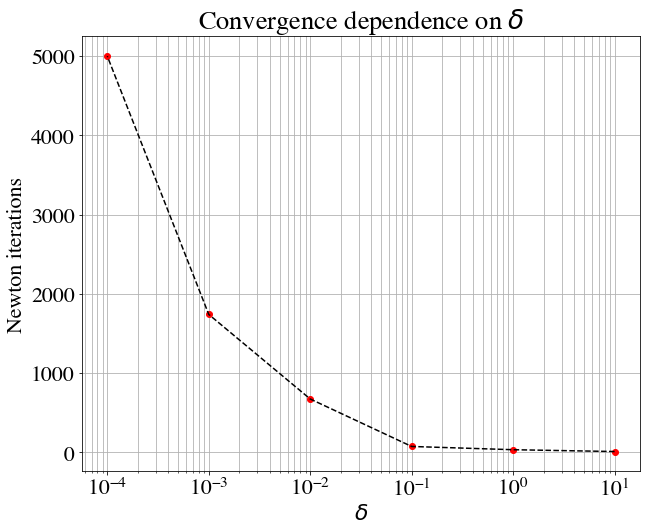

In [9]:
# TN regularization
alpha = 1e-2
deltas= np.logspace(1,-4,6)
num_iters=[]

for delta in deltas:
    u_tv = Function(V)
    F_tv = TV_functions(alpha,delta,u_tv)
    solver.solve(F_tv, u_tv)
    num_iters.append(solver.it)
# plot iteration dependence on the delta
fig,ax = plt.subplots(figsize=(10,8))
ax.semilogx(deltas, num_iters,'ro')
ax.semilogx(deltas, num_iters,'k--')
plt.grid(True, which="both")
plt.xlabel(r'$\delta$')
plt.ylabel(r'Newton iterations')
plt.title("Convergence dependence on $\delta$")
plt.savefig("Q4_TV_Newton.pdf") 

## Increasing the $\delta$ causes a sharp drop in the Newton steps for convergence, plateauing at almost a constant value. This happens as Hessian becomes more ill-conditioned when the $\delta$ is reduced. Also, the size of the valley of optimal convergence also reduces with decreasing $\delta$. So, it takes more steps to find that valley.

# Part(c): Comparing the best reconstructions for Tikhonov and Total Variation Reconstructions

Using Symbolic Differentiation to compute the gradient
Using Symbolic Differentiation to compute the Hessian
 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    1.859864e-01    5.212611e-03   -1.795858e-01    1.000000e+00    5.000000e-01       1
  1    1.201357e-01    9.879401e-03   -1.191994e-01    1.000000e+00    5.000000e-01       1
  2    1.152185e-01    1.385010e-02   -6.056340e-02    5.000000e-01    5.000000e-01       1
  3    1.106088e-01    1.279555e-02   -3.785992e-01    6.250000e-02    5.000000e-01       1
  4    1.046458e-01    1.151200e-02   -3.269478e-01    3.125000e-02    5.000000e-01       1
  5    1.042907e-01    1.095296e-02   -1.627935e-01    3.125000e-02    5.000000e-01       1
  6    1.037626e-01    1.052778e-02   -1.580796e-01    3.125000e-02    5.000000e-01       1
  7    1.037016e-01    1.017335e-02   -1.692858e-01    3.125000e-02    5.000000e-01       1
  8    1.032060e-01    9.900013e-03   -1.701277e-01    3.125000

 87    9.419554e-02    2.799538e-03   -7.687458e-03    7.812500e-03    5.000000e-01       1
 88    9.417810e-02    2.809105e-03   -7.282012e-03    7.812500e-03    5.000000e-01       1
 89    9.416329e-02    2.771493e-03   -7.681874e-03    7.812500e-03    5.000000e-01       1
 90    9.414600e-02    2.781937e-03   -7.274663e-03    7.812500e-03    5.000000e-01       1
 91    9.413148e-02    2.744080e-03   -7.662642e-03    7.812500e-03    5.000000e-01       1
 92    9.411437e-02    2.755355e-03   -7.255854e-03    7.812500e-03    5.000000e-01       1
 93    9.410014e-02    2.717271e-03   -7.636610e-03    7.812500e-03    5.000000e-01       1
 94    9.408322e-02    2.729335e-03   -7.230902e-03    7.812500e-03    5.000000e-01       1
 95    9.406925e-02    2.691040e-03   -7.607168e-03    7.812500e-03    5.000000e-01       1
 96    9.405252e-02    2.703861e-03   -7.202599e-03    7.812500e-03    5.000000e-01       1
 97    9.403880e-02    2.665368e-03   -7.575999e-03    7.812500e-03    5.000000e

177    9.310724e-02    1.958782e-03   -6.412412e-03    7.812500e-03    5.000000e-01       1
178    9.309721e-02    1.991320e-03   -6.026485e-03    7.812500e-03    5.000000e-01       1
179    9.308966e-02    1.946668e-03   -6.389015e-03    7.812500e-03    5.000000e-01       1
180    9.307975e-02    1.979554e-03   -6.003637e-03    7.812500e-03    5.000000e-01       1
181    9.307229e-02    1.934736e-03   -6.365944e-03    7.812500e-03    5.000000e-01       1
182    9.306250e-02    1.967967e-03   -5.981118e-03    7.812500e-03    5.000000e-01       1
183    9.305515e-02    1.922983e-03   -6.343203e-03    7.812500e-03    5.000000e-01       1
184    9.304547e-02    1.956554e-03   -5.958935e-03    7.812500e-03    5.000000e-01       1
185    9.303821e-02    1.911403e-03   -6.320797e-03    7.812500e-03    5.000000e-01       1
186    9.302865e-02    1.945313e-03   -5.937090e-03    7.812500e-03    5.000000e-01       1
187    9.302148e-02    1.899994e-03   -6.298730e-03    7.812500e-03    5.000000e

267    9.247832e-02    1.546227e-03   -5.640540e-03    7.812500e-03    4.754616e-01       1
268    9.247197e-02    1.591967e-03   -5.276781e-03    7.812500e-03    4.675981e-01       1
269    9.246731e-02    1.539344e-03   -5.624634e-03    7.812500e-03    4.744639e-01       1
270    9.246103e-02    1.585342e-03   -5.261388e-03    7.812500e-03    4.665562e-01       1
271    9.245642e-02    1.532538e-03   -5.608778e-03    7.812500e-03    4.734755e-01       1
272    9.245021e-02    1.578791e-03   -5.246053e-03    7.812500e-03    4.655236e-01       1
273    9.244565e-02    1.525808e-03   -5.592988e-03    7.812500e-03    4.724964e-01       1
274    9.243951e-02    1.572316e-03   -5.230791e-03    7.812500e-03    4.645003e-01       1
275    9.243500e-02    1.519151e-03   -5.577277e-03    7.812500e-03    4.715263e-01       1
276    9.242893e-02    1.565913e-03   -5.215612e-03    7.812500e-03    4.634860e-01       1
277    9.242448e-02    1.512568e-03   -5.561656e-03    7.812500e-03    4.705653e

357    9.208887e-02    1.296627e-03   -5.041445e-03    7.812500e-03    4.380751e-01       1
358    9.208503e-02    1.352831e-03   -4.701127e-03    7.812500e-03    4.281970e-01       1
359    9.208225e-02    1.292137e-03   -5.030802e-03    7.812500e-03    4.373789e-01       1
360    9.207844e-02    1.348554e-03   -4.690963e-03    7.812500e-03    4.274550e-01       1
361    9.207570e-02    1.287680e-03   -5.020255e-03    7.812500e-03    4.366870e-01       1
362    9.207193e-02    1.344309e-03   -4.680894e-03    7.812500e-03    4.267171e-01       1
363    9.206921e-02    1.283255e-03   -5.009802e-03    7.812500e-03    4.359991e-01       1
364    9.206549e-02    1.340095e-03   -4.670917e-03    7.812500e-03    4.259833e-01       1
365    9.206280e-02    1.278861e-03   -4.999442e-03    7.812500e-03    4.353153e-01       1
366    9.205911e-02    1.335913e-03   -4.661032e-03    7.812500e-03    4.252534e-01       1
367    9.205645e-02    1.274499e-03   -4.989175e-03    7.812500e-03    4.346355e

447    9.184809e-02    1.119843e-03   -4.641086e-03    7.812500e-03    4.099828e-01       1
448    9.184563e-02    1.185366e-03   -4.320662e-03    7.812500e-03    3.979373e-01       1
449    9.184382e-02    1.116352e-03   -4.633595e-03    7.812500e-03    4.094137e-01       1
450    9.184138e-02    1.182082e-03   -4.313582e-03    7.812500e-03    3.973166e-01       1
451    9.183958e-02    1.112874e-03   -4.626147e-03    7.812500e-03    4.088462e-01       1
452    9.183717e-02    1.178811e-03   -4.306542e-03    7.812500e-03    3.966972e-01       1
453    9.183538e-02    1.109409e-03   -4.618738e-03    7.812500e-03    4.082801e-01       1
454    9.183299e-02    1.175553e-03   -4.299541e-03    7.812500e-03    3.960790e-01       1
455    9.183122e-02    1.105956e-03   -4.611367e-03    7.812500e-03    4.077155e-01       1
456    9.182886e-02    1.172308e-03   -4.292575e-03    7.812500e-03    3.954622e-01       1
457    9.182710e-02    1.102515e-03   -4.604030e-03    7.812500e-03    4.071523e

537    9.168701e-02    9.746224e-04   -4.333842e-03    7.812500e-03    3.858021e-01       1
538    9.168538e-02    1.049889e-03   -4.031386e-03    7.812500e-03    3.712396e-01       1
539    9.168406e-02    9.717215e-04   -4.327007e-03    7.812500e-03    3.853078e-01       1
540    9.168244e-02    1.047212e-03   -4.024922e-03    7.812500e-03    3.706867e-01       1
541    9.168113e-02    9.688390e-04   -4.320094e-03    7.812500e-03    3.848163e-01       1
542    9.167953e-02    1.044554e-03   -4.018394e-03    7.812500e-03    3.701365e-01       1
543    9.167823e-02    9.659749e-04   -4.313115e-03    7.812500e-03    3.843275e-01       1
544    9.167665e-02    1.041913e-03   -4.011812e-03    7.812500e-03    3.695890e-01       1
545    9.167536e-02    9.631288e-04   -4.306079e-03    7.812500e-03    3.838415e-01       1
546    9.167379e-02    1.039291e-03   -4.005184e-03    7.812500e-03    3.690441e-01       1
547    9.167252e-02    9.603005e-04   -4.298993e-03    7.812500e-03    3.833581e

627    9.157725e-02    8.595434e-04   -3.953446e-03    7.812500e-03    3.659056e-01       1
628    9.157629e-02    9.447760e-04   -3.674745e-03    7.812500e-03    3.486342e-01       1
629    9.157525e-02    8.572918e-04   -3.939152e-03    7.812500e-03    3.655111e-01       1
630    9.157430e-02    9.427471e-04   -3.661165e-03    7.812500e-03    3.481773e-01       1
631    9.157326e-02    8.550514e-04   -3.923779e-03    7.812500e-03    3.651184e-01       1
632    9.157232e-02    9.407302e-04   -3.646502e-03    7.812500e-03    3.477220e-01       1
633    9.157128e-02    8.528221e-04   -3.907080e-03    7.812500e-03    3.647276e-01       1
634    9.157036e-02    9.387251e-04   -3.630498e-03    7.812500e-03    3.472684e-01       1
635    9.156931e-02    8.506039e-04   -3.888723e-03    7.812500e-03    3.643387e-01       1
636    9.156840e-02    9.367319e-04   -3.612800e-03    7.812500e-03    3.468165e-01       1
637    9.156735e-02    8.483964e-04   -3.868252e-03    7.812500e-03    3.639517e

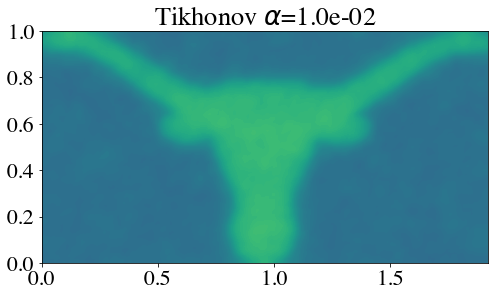

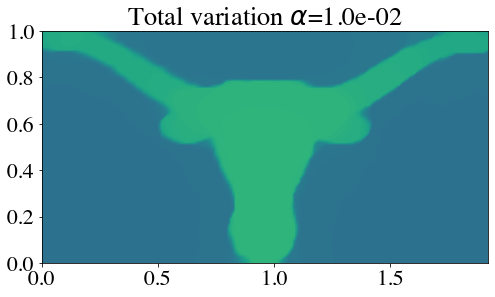

In [11]:
#Best reconstructions
#TN Regularization
alpha = 1e-3
u_tn = Function(V)
# linear solve
a_tn, L_tn = TN_functions(alpha)
solve(a_tn==L_tn, u_tn)

#TV Regularization
alpha = 1e-2
delta  = 0.01
u_tv = Function(V)
F_tv = TV_functions(alpha,delta,u_tv)
solver.solve(F_tv, u_tv)

# Misfit
res_tv_norm.append(np.linalg.norm(u_tv.vector()[:] - u_0.vector()[:]))
u_tv_norm.append(np.linalg.norm(u_tv.vector()[:]))
u_tv_list.append(u_tv.copy())

#plotting the images
plt.figure(figsize=(8,8))
plot(u_tn, title="Tikhonov $\\alpha$=%.1e" %(alpha), vmin=vmin, vmax = vmax)
plt.figure(figsize=(8,8))
plot(u_tv, title="Total variation $\\alpha$=%.1e" %(alpha), vmin=vmin, vmax = vmax)

## From the optimal results for TV and TN regularizations, it is evident that the TV regularization preserves the edges but TN regularization smears sharp edges. This occurs since TN solves the diffusion problem isotropically, i.e., both in the direction of fastest gradient and its perpedicular direction. 

## However, TV solves the diffusion problem in the direction perpendicular to the steepest gradient. This leads to the Newton steps that encourage diffusion and subsequently, smoothness. Moreover, it discourages diffusion and preserves sharp edges in the direction of the gradients.